**Student's Full Name:** Melahat Tayli

**Homework Name:** Final Project

### Import Python Packages/Libraries Here

In [1]:
# import libraries here
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import tensorflow as tf
from tensorflow.keras import layers, models

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error

import pmdarima as pm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.stats.diagnostic import acorr_ljungbox 
from statsmodels.graphics.gofplots import qqplot
from pmdarima import auto_arima
import warnings
warnings.filterwarnings('ignore')

## Project Purpose
This project aims to predict energy consumption in smart homes by analyzing historical energy usage data. By identifying patterns and trends in energy usage, we can develop strategies to reduce energy consumption and lower costs. I will explore how factors such as time of day, season, and weather conditions influence energy usage.

### About the Dataset

- The dataset name is **“Smart Home Dataset with Weather Information”**, available on [Kaggle](https://www.kaggle.com/taranvee/smart-home-dataset-with-weather-information).  
- Key details about the dataset:
  - Contains over 500,000 data points recorded at 1-minute intervals.
  - Covers the entire year of 2016.
  - Includes energy consumption data (in kW) for various smart home appliances and rooms.
  - Provides corresponding weather data for the region (region is unknown).  
- The dataset enables:
  - Comprehensive analysis of energy usage patterns in a smart home.
  - Exploration of potential correlations between appliance energy consumption and weather conditions.




## Upload and Preprocess the Dataset

In [2]:
df = pd.read_csv('./data.csv', low_memory=False)
df.head()

,time,use [kW],gen [kW],House overall [kW],Dishwasher [kW],Furnace 1 [kW],Furnace 2 [kW],Home office [kW],Fridge [kW],Wine cellar [kW],...,visibility,summary,apparentTemperature,pressure,windSpeed,cloudCover,windBearing,precipIntensity,dewPoint,precipProbability
0,1451624400,0.932833,0.003483,0.932833,0.000033,0.020700,0.061917,0.442633,0.124150,0.006983,...,10.0,Clear,29.26,1016.91,9.18,cloudCover,282.0,0.0,24.4,0.0
1,1451624401,0.934333,0.003467,0.934333,0.000000,0.020717,0.063817,0.444067,0.124000,0.006983,...,10.0,Clear,29.26,1016.91,9.18,cloudCover,282.0,0.0,24.4,0.0
2,1451624402,0.931817,0.003467,0.931817,0.000017,0.020700,0.062317,0.446067,0.123533,0.006983,...,10.0,Clear,29.26,1016.91,9.18,cloudCover,282.0,0.0,24.4,0.0
3,1451624403,1.022050,0.003483,1.022050,0.000017,0.106900,0.068517,0.446583,0.123133,0.006983,...,10.0,Clear,29.26,1016.91,9.18,cloudCover,282.0,0.0,24.4,0.0
4,1451624404,1.139400,0.003467,1.139400,0.000133,0.236933,0.063983,0.446533,0.122850,0.006850,...,10.0,Clear,29.26,1016.91,9.18,cloudCover,282.0,0.0,24.4,0.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 503911 entries, 0 to 503910
Data columns (total 32 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   time                 503911 non-null  object 
 1   use [kW]             503910 non-null  float64
 2   gen [kW]             503910 non-null  float64
 3   House overall [kW]   503910 non-null  float64
 4   Dishwasher [kW]      503910 non-null  float64
 5   Furnace 1 [kW]       503910 non-null  float64
 6   Furnace 2 [kW]       503910 non-null  float64
 7   Home office [kW]     503910 non-null  float64
 8   Fridge [kW]          503910 non-null  float64
 9   Wine cellar [kW]     503910 non-null  float64
 10  Garage door [kW]     503910 non-null  float64
 11  Kitchen 12 [kW]      503910 non-null  float64
 12  Kitchen 14 [kW]      503910 non-null  float64
 13  Kitchen 38 [kW]      503910 non-null  float64
 14  Barn [kW]            503910 non-null  float64
 15  Well [kW]        

#### Comment  
The dataset comprises 32 columns and 503,911 data points. However, some columns contain missing values. Time column is parsed as an object.

### Convert time columns to datetime

In [4]:
df['time'] = pd.to_datetime(pd.to_numeric(df['time'], errors='coerce'), unit='s')
df[['time']].head()

,time
0,2016-01-01 05:00:00
1,2016-01-01 05:00:01
2,2016-01-01 05:00:02
3,2016-01-01 05:00:03
4,2016-01-01 05:00:04


##### Comment
The time values should increment in minutes instead of the current format. This needs to be corrected.

In [5]:
# Generate a DatetimeIndex with minute increments
df['time'] = pd.date_range('2016-01-01 05:00', periods=len(df), freq='min')
df[['time']].head()

,time
0,2016-01-01 05:00:00
1,2016-01-01 05:01:00
2,2016-01-01 05:02:00
3,2016-01-01 05:03:00
4,2016-01-01 05:04:00


### Extract year, month, week, day, hour, and minutes from the datetime column to create new features

In [6]:
df['year'] = df['time'].dt.year
df['month'] = df['time'].dt.month
df['day'] = df['time'].dt.day
df['weekday'] = df['time'].dt.day_name()
df['weekofyear'] = df['time'].dt.isocalendar().week
df['hour'] = df['time'].dt.hour
df['minute'] = df['time'].dt.minute
df.head()

,time,use [kW],gen [kW],House overall [kW],Dishwasher [kW],Furnace 1 [kW],Furnace 2 [kW],Home office [kW],Fridge [kW],Wine cellar [kW],...,precipIntensity,dewPoint,precipProbability,year,month,day,weekday,weekofyear,hour,minute
0,2016-01-01 05:00:00,0.932833,0.003483,0.932833,0.000033,0.020700,0.061917,0.442633,0.124150,0.006983,...,0.0,24.4,0.0,2016,1,1,Friday,53,5,0
1,2016-01-01 05:01:00,0.934333,0.003467,0.934333,0.000000,0.020717,0.063817,0.444067,0.124000,0.006983,...,0.0,24.4,0.0,2016,1,1,Friday,53,5,1
2,2016-01-01 05:02:00,0.931817,0.003467,0.931817,0.000017,0.020700,0.062317,0.446067,0.123533,0.006983,...,0.0,24.4,0.0,2016,1,1,Friday,53,5,2
3,2016-01-01 05:03:00,1.022050,0.003483,1.022050,0.000017,0.106900,0.068517,0.446583,0.123133,0.006983,...,0.0,24.4,0.0,2016,1,1,Friday,53,5,3
4,2016-01-01 05:04:00,1.139400,0.003467,1.139400,0.000133,0.236933,0.063983,0.446533,0.122850,0.006850,...,0.0,24.4,0.0,2016,1,1,Friday,53,5,4


In [7]:
# Convert weekday names to integers using a mapping dictionary
weekday_to_int = {"Monday": 0, "Tuesday": 1, "Wednesday": 2, "Thursday": 3, 
                  "Friday": 4, "Saturday": 5, "Sunday": 6}

df['weekday'] = df['weekday'].map(weekday_to_int)
df[['weekday']].head(10)

,weekday
0,4
1,4
2,4
3,4
4,4
5,4
6,4
7,4
8,4
9,4


In [8]:
# Drop the 'time' column as its components (year, month, week, etc.) have already been extracted
df.drop(columns=['time'], inplace=True)

### Drop the Null Values

In [9]:
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 503910 entries, 0 to 503909
Data columns (total 38 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   use [kW]             503910 non-null  float64
 1   gen [kW]             503910 non-null  float64
 2   House overall [kW]   503910 non-null  float64
 3   Dishwasher [kW]      503910 non-null  float64
 4   Furnace 1 [kW]       503910 non-null  float64
 5   Furnace 2 [kW]       503910 non-null  float64
 6   Home office [kW]     503910 non-null  float64
 7   Fridge [kW]          503910 non-null  float64
 8   Wine cellar [kW]     503910 non-null  float64
 9   Garage door [kW]     503910 non-null  float64
 10  Kitchen 12 [kW]      503910 non-null  float64
 11  Kitchen 14 [kW]      503910 non-null  float64
 12  Kitchen 38 [kW]      503910 non-null  float64
 13  Barn [kW]            503910 non-null  float64
 14  Well [kW]            503910 non-null  float64
 15  Microwave [kW]       5

#### Comment
- After removing missing values, each column now contains 503,910 data points.  
- The predictors `icon`, `summary`, and `cloudCover` are parsed as objects. Let's further investigate these variables.


In [10]:
df[['icon', 'summary', 'cloudCover']]

,icon,summary,cloudCover
0,clear-night,Clear,cloudCover
1,clear-night,Clear,cloudCover
2,clear-night,Clear,cloudCover
3,clear-night,Clear,cloudCover
4,clear-night,Clear,cloudCover
...,...,...,...
503905,rain,Light Rain,0.31
503906,rain,Light Rain,0.31
503907,rain,Light Rain,0.31
503908,rain,Light Rain,0.31


### Comment

- The `cloudCover` predictor contains a mix of numeric and string values, which can complicate analysis.  
- The `summary` and `icon` variables provide qualitative descriptions of the weather, such as whether it is a rainy or clear day.  
- While these variables are useful for descriptive purposes, the dataset includes other quantitative weather variables like `temperature` and `humidity`, which provide more precise and actionable insights.  
- Given the availability of these detailed weather predictors, I will:
  - **Drop** the `cloudCover`, `summary`, and `icon` variables to simplify the dataset and focus on numerical predictors.


In [11]:
df.drop(['icon', 'summary', 'cloudCover'], axis=1, inplace=True)

### Simplify Variable Names and Combine Related Features

- Combine related features, such as `Furnace 1` and `Furnace 2`, into a single variable to reduce redundancy and simplify analysis.
- Change variable names for better readability and consistency.    


In [12]:
# Combine Features: Total Energy Usage by Both Furnaces
df['furnace_use'] = df[['Furnace 1 [kW]','Furnace 2 [kW]']].sum(axis=1)

# Verify the new column
print(df[['Furnace 1 [kW]', 'Furnace 2 [kW]', 'furnace_use']].head())

   Furnace 1 [kW]  Furnace 2 [kW]  furnace_use
0        0.020700        0.061917     0.082617
1        0.020717        0.063817     0.084533
2        0.020700        0.062317     0.083017
3        0.106900        0.068517     0.175417
4        0.236933        0.063983     0.300917


In [13]:
# Calculate the Average Usage Across All Kitchens
# Combining 'Kitchen 12', 'Kitchen 14', and 'Kitchen 38' into a single 'Kitchen' column
df['kitchen_use'] = df[['Kitchen 12 [kW]', 'Kitchen 14 [kW]', 'Kitchen 38 [kW]']].mean(axis=1)

# Verify the new column
print(df[['Kitchen 12 [kW]', 'Kitchen 14 [kW]', 'Kitchen 38 [kW]', 'kitchen_use']].head())


   Kitchen 12 [kW]  Kitchen 14 [kW]  Kitchen 38 [kW]  kitchen_use
0         0.000417         0.000150         0.000000     0.000189
1         0.000417         0.000150         0.000000     0.000189
2         0.000433         0.000167         0.000017     0.000206
3         0.000433         0.000217         0.000000     0.000217
4         0.000450         0.000333         0.000000     0.000261


In [14]:
df.drop(['Kitchen 12 [kW]',  'Kitchen 14 [kW]',  'Kitchen 38 [kW]', 'Furnace 1 [kW]', 'Furnace 2 [kW]'], axis=1, inplace=True)

In [15]:
df.columns

Index(['use [kW]', 'gen [kW]', 'House overall [kW]', 'Dishwasher [kW]',
       'Home office [kW]', 'Fridge [kW]', 'Wine cellar [kW]',
       'Garage door [kW]', 'Barn [kW]', 'Well [kW]', 'Microwave [kW]',
       'Living room [kW]', 'Solar [kW]', 'temperature', 'humidity',
       'visibility', 'apparentTemperature', 'pressure', 'windSpeed',
       'windBearing', 'precipIntensity', 'dewPoint', 'precipProbability',
       'year', 'month', 'day', 'weekday', 'weekofyear', 'hour', 'minute',
       'furnace_use', 'kitchen_use'],
      dtype='object')

In [16]:
df = df.rename(columns={
    'use [kW]': 'use',
    'gen [kW]': 'gen',
    'House overall [kW]':'house_overall_use',
    'Dishwasher [kW]': 'dishwasher_use',
    'Home office [kW]': 'home_office_use',
    'Fridge [kW]': 'fridge_use', 
    'Wine cellar [kW]':'wine_cellar_use',
    'Garage door [kW]': 'garage_door_use',
    'Barn [kW]': 'barn_use',
    'Well [kW]': 'well_use',
    'Microwave [kW]':'microwave_use',
    'Living room [kW]':'living_room_use',
    'Solar [kW]':'solar_use'
})

print("Column names:\n", list(df.columns))

Column names:
 ['use', 'gen', 'house_overall_use', 'dishwasher_use', 'home_office_use', 'fridge_use', 'wine_cellar_use', 'garage_door_use', 'barn_use', 'well_use', 'microwave_use', 'living_room_use', 'solar_use', 'temperature', 'humidity', 'visibility', 'apparentTemperature', 'pressure', 'windSpeed', 'windBearing', 'precipIntensity', 'dewPoint', 'precipProbability', 'year', 'month', 'day', 'weekday', 'weekofyear', 'hour', 'minute', 'furnace_use', 'kitchen_use']


### Identify and remove columns with identical values across all rows

Such columns offer no useful information for model training or prediction and can be safely dropped to simplify the dataset.

In [17]:
singleton_columns = df.columns[df.nunique() == 1]
if len(singleton_columns) == 0:
    print("There is no constant columns in the data")
else:
    print(f"Removing singleton columns from data: {singleton_columns.tolist()}")
    df = df.drop(columns=singleton_columns)

Removing singleton columns from data: ['year']


### Check for Correlation in the Data and Remove Highly Correlated Columns
- Analyze the dataset to identify correlations between variables.  
- Remove columns with high correlation to reduce redundancy and prevent multicollinearity in the analysis.  


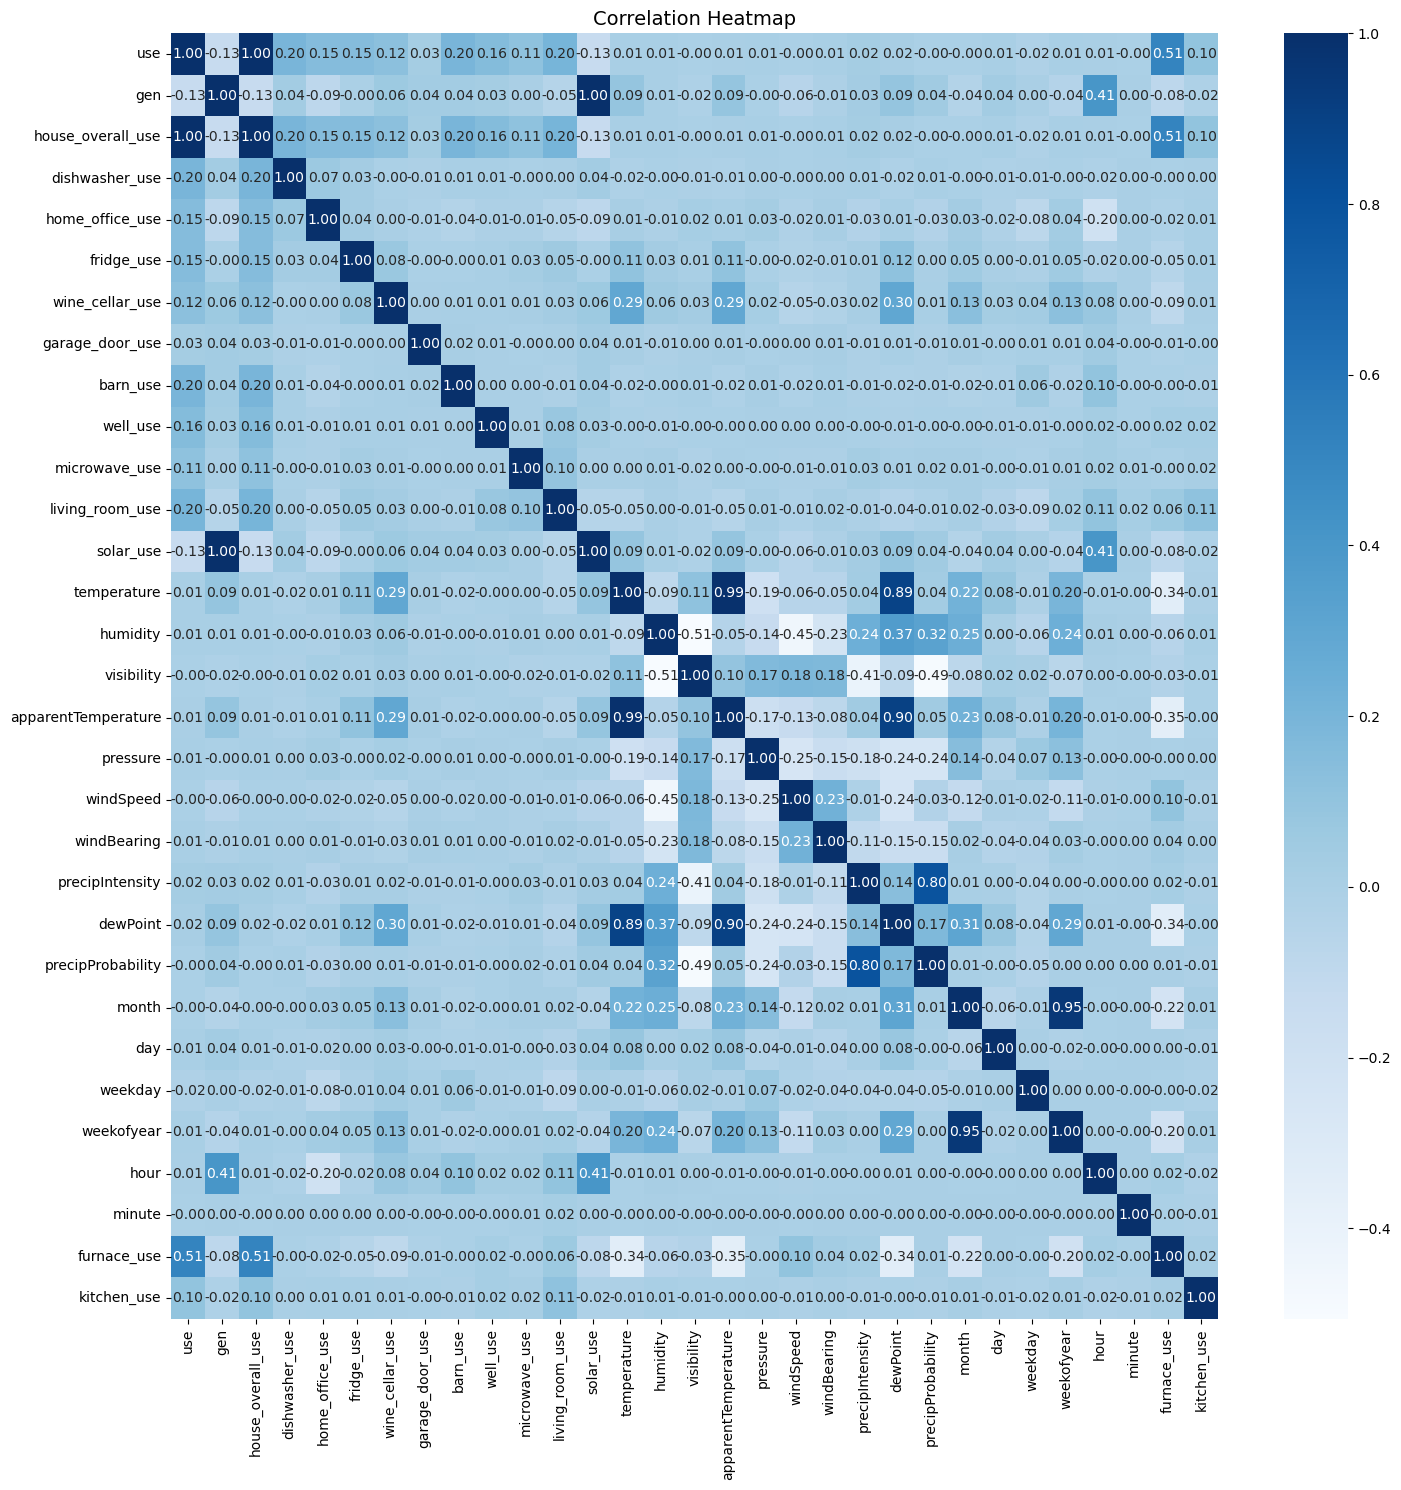

In [18]:
# Calculate the correlation matrix
correlation_df = df.corr()

# Create a heatmap
plt.figure(figsize=(15, 15))
sns.heatmap(correlation_df, annot=True, fmt=".2f", cmap='Blues', cbar=True)

plt.title("Correlation Heatmap", fontsize=14)
plt.tight_layout()
plt.show()


In [19]:
def find_correlated_features(df, threshold=0.75):
    # Calculate the correlation matrix
    corr_matrix = df.corr().abs()

    # Create a mask to select upper triangle of the correlation matrix
    upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    # Find columns with correlations above the threshold
    correlated_features=[]
    for column in df.columns:
        if any(upper_tri[column] > threshold):
            correlated_features.append(column)

    return  correlated_features

In [20]:
correlated_features = find_correlated_features(df)
print(f"Number of correlated features in train data: {len(correlated_features)}")
print(f"Correlated features: {correlated_features}")

Number of correlated features in train data: 6
Correlated features: ['house_overall_use', 'solar_use', 'apparentTemperature', 'dewPoint', 'precipProbability', 'weekofyear']


In [21]:
print(f"\n.. Dropping  {len(correlated_features)} correlated variables from the data\n")
df = df.drop(correlated_features, axis=1)
print(f"Shape of the data after removing correlation: {df.shape}")



.. Dropping  6 correlated variables from the data

Shape of the data after removing correlation: (503910, 25)


In [22]:
df

,use,gen,dishwasher_use,home_office_use,fridge_use,wine_cellar_use,garage_door_use,barn_use,well_use,microwave_use,...,windSpeed,windBearing,precipIntensity,month,day,weekday,hour,minute,furnace_use,kitchen_use
0,0.932833,0.003483,0.000033,0.442633,0.124150,0.006983,0.013083,0.031350,0.001017,0.004067,...,9.18,282.0,0.0000,1,1,4,5,0,0.082617,0.000189
1,0.934333,0.003467,0.000000,0.444067,0.124000,0.006983,0.013117,0.031500,0.001017,0.004067,...,9.18,282.0,0.0000,1,1,4,5,1,0.084533,0.000189
2,0.931817,0.003467,0.000017,0.446067,0.123533,0.006983,0.013083,0.031517,0.001000,0.004067,...,9.18,282.0,0.0000,1,1,4,5,2,0.083017,0.000206
3,1.022050,0.003483,0.000017,0.446583,0.123133,0.006983,0.013000,0.031500,0.001017,0.004067,...,9.18,282.0,0.0000,1,1,4,5,3,0.175417,0.000217
4,1.139400,0.003467,0.000133,0.446533,0.122850,0.006850,0.012783,0.031500,0.001017,0.004067,...,9.18,282.0,0.0000,1,1,4,5,4,0.300917,0.000261
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
503905,1.601233,0.003183,0.000050,0.041783,0.005267,0.008667,0.013483,0.032283,0.000983,0.003800,...,6.72,186.0,0.0101,12,16,4,3,25,0.727683,0.000211
503906,1.599333,0.003233,0.000050,0.041750,0.005233,0.008433,0.013433,0.032200,0.000950,0.003800,...,6.72,186.0,0.0101,12,16,4,3,26,0.729050,0.000200
503907,1.924267,0.003217,0.000033,0.042033,0.004983,0.008467,0.012933,0.032283,0.001000,0.003750,...,6.72,186.0,0.0101,12,16,4,3,27,1.060117,0.000200
503908,1.978200,0.003217,0.000050,0.042100,0.005333,0.008233,0.012817,0.032183,0.000950,0.003767,...,6.72,186.0,0.0101,12,16,4,3,28,1.116033,0.000217


## Analyze Trends Between Energy Consumption/Generation and Weather

### Analysis:Energy Consumption Trends for Appliances and Rooms
 
- The objective is to determine which appliances/rooms consume the most energy on average.


In [23]:
# Define columns for room and appliance energy usage
rooms = [
    'home_office_use', 
    'wine_cellar_use',
    'barn_use', 
    'living_room_use',
    'kitchen_use'
]

appliances = [
    'dishwasher_use',  
    'fridge_use',
    'garage_door_use', 
    'well_use',
    'microwave_use', 
    'furnace_use'
]

### Average Energy Usage by Appliances and Rooms

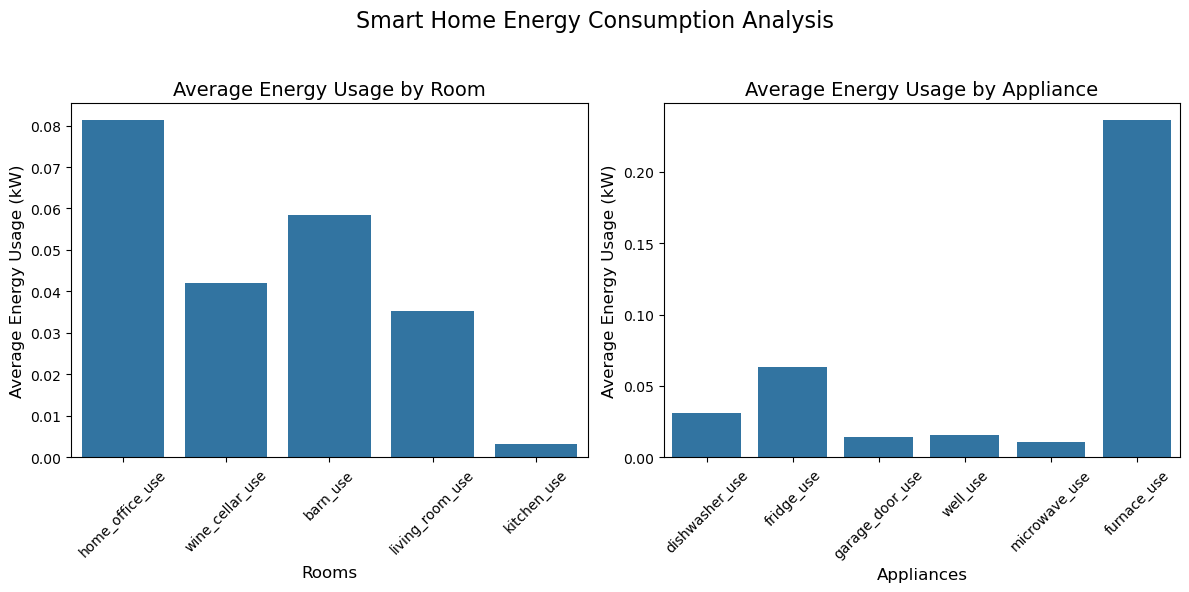

In [24]:
# Calculate the average energy usage for rooms and appliances
average_energy_usage_rooms = df[rooms].mean(axis=0)
average_energy_usage_appliances = df[appliances].mean(axis=0)

# Visualize
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Plot average energy usage for rooms
sns.barplot(x=average_energy_usage_rooms.index, 
            y=average_energy_usage_rooms.values, 
            ax=ax[0])
ax[0].set_title("Average Energy Usage by Room", fontsize=14)
ax[0].set_xlabel("Rooms", fontsize=12)
ax[0].set_ylabel("Average Energy Usage (kW)", fontsize=12)
ax[0].tick_params(axis='x', rotation=45)

# Plot average energy usage for appliances
sns.barplot(x=average_energy_usage_appliances.index, 
            y=average_energy_usage_appliances.values, 
            ax=ax[1])
ax[1].set_title("Average Energy Usage by Appliance", fontsize=14)
ax[1].set_xlabel("Appliances", fontsize=12)
ax[1].set_ylabel("Average Energy Usage (kW)", fontsize=12)
ax[1].tick_params(axis='x', rotation=45)

# Adjust layout and display the plots
plt.suptitle("Smart Home Energy Consumption Analysis", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to fit title
plt.show()


### Comment

- The furnace shows significantly higher energy consumption compared to other appliances.  
- The home office has notably higher energy usage than other rooms, likely due to extended periods of activity, such as working or engaging in leisure activities.


### Average Hourly Energy Usage by Appliances and Rooms

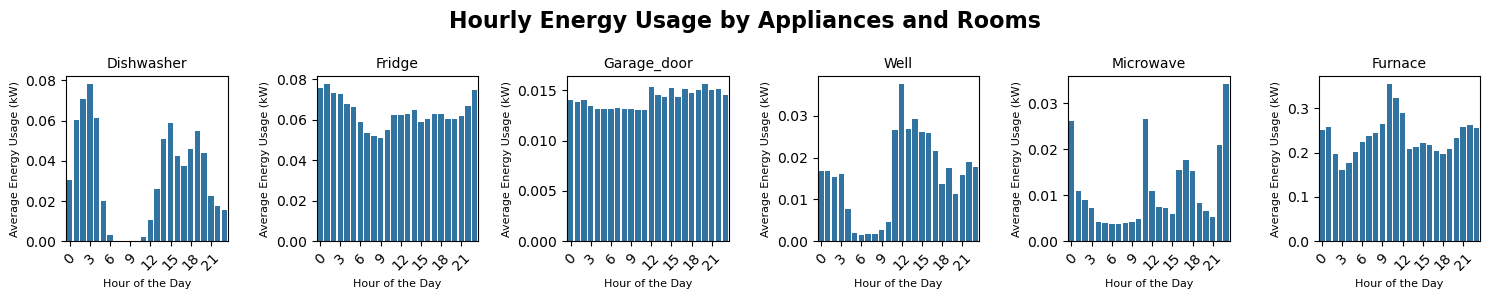

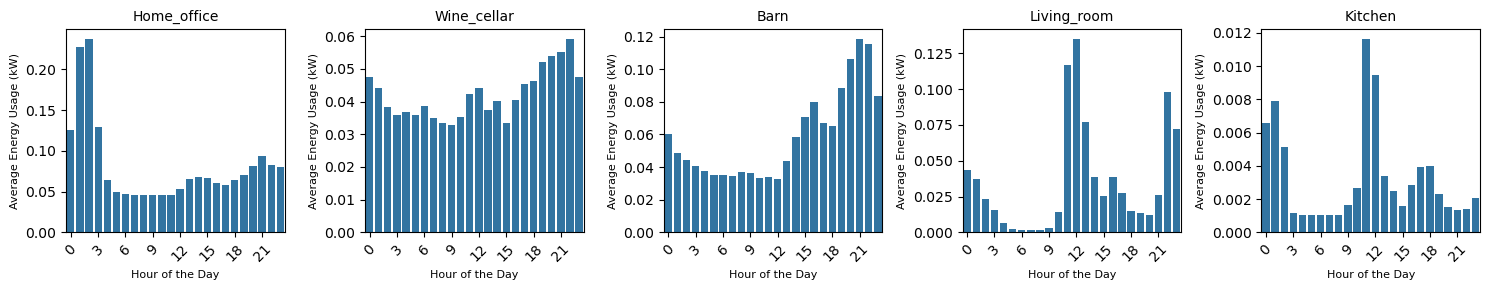

In [25]:
# Group data by hour and calculate average energy usage for appliances and rooms
df_aggr_hourly = df.groupby('hour').mean().reset_index()

# Plot average energy usage per appliance across hours
fig, ax = plt.subplots(1, len(appliances), figsize=(15, 3))
ax = ax.flatten()

for i, appliance in enumerate(appliances):
    sns.barplot(x=df_aggr_hourly['hour'], 
                y=df_aggr_hourly[appliance], ax=ax[i])
    ax[i].set_title(f"{appliance.replace('_use', '').capitalize()}", fontsize=10)
    ax[i].set_xlabel("Hour of the Day", fontsize=8)
    ax[i].set_ylabel("Average Energy Usage (kW)", fontsize=8)
    ax[i].set_xticks(np.arange(0, 24, 3))  # Set x-ticks at every 3 hours
    ax[i].tick_params(axis='x', rotation=45)  # Rotate x-axis labels for better readability

plt.suptitle("Hourly Energy Usage by Appliances and Rooms", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Plot average energy usage per room across hours
fig, ax = plt.subplots(1, len(rooms), figsize=(15, 3))  # Adjusted figure size for better readability
ax = ax.flatten()

for i, room in enumerate(rooms):
    sns.barplot(x=df_aggr_hourly['hour'], 
                y=df_aggr_hourly[room], ax=ax[i])  # Corrected to use the current room
    ax[i].set_title(f"{room.replace('_use', '').capitalize()}", fontsize=10)
    ax[i].set_xlabel("Hour of the Day", fontsize=8)
    ax[i].set_ylabel("Average Energy Usage (kW)", fontsize=8)
    ax[i].set_xticks(np.arange(0, 24, 3))  # Set x-ticks at every 3 hours
    ax[i].tick_params(axis='x', rotation=45)  # Rotate x-axis labels for better readability

plt.tight_layout()
plt.show()


### Analysis: Comparison of Total Energy Consumption and Generation

- This section analyzes the relationship between total energy consumption and generation.


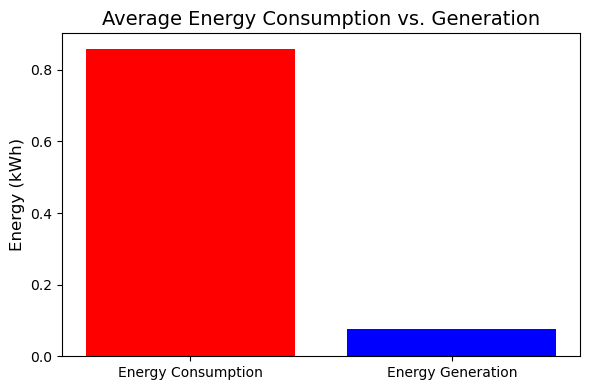

In [26]:
# Calculate average energy consumption and generation
average_energy_use = df['use'].mean()
average_energy_generation = df['gen'].mean()

# Create a bar plot for average energy usage and generation
plt.figure(figsize=(6, 4))
plt.bar(x=['Energy Consumption', 'Energy Generation'], height=[average_energy_use, average_energy_generation], color=['red', 'blue'])
plt.title("Average Energy Consumption vs. Generation", fontsize=14)
plt.ylabel("Energy (kWh)", fontsize=12)
plt.tight_layout()
plt.show()


### Comment
Observation: **Energy Imbalance**

The home consumes more energy than it generates. This indicates a need for additional energy sources or energy efficiency measures.

### Analysis: Energy Consumption and Weather Temperature


In [27]:
# Calculate summary statistics for the 'temperature' column
temperature_statistics = df['temperature'].describe()

# Display the statistics
print(temperature_statistics)


count    503910.000000
mean         50.741935
std          19.113807
min         -12.640000
25%          35.770000
50%          50.320000
75%          66.260000
max          93.720000
Name: temperature, dtype: float64


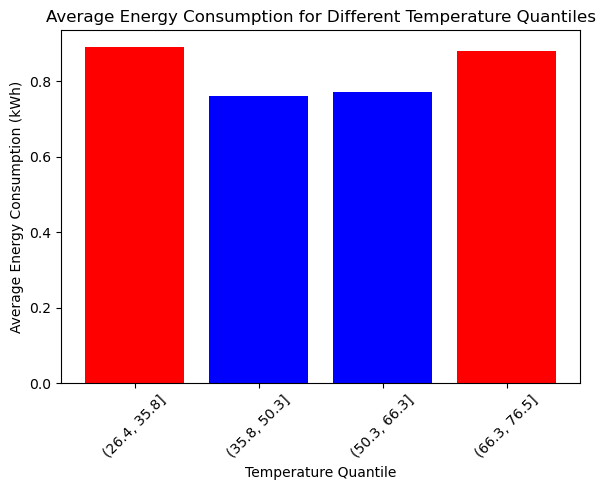

In [28]:
# Calculate energy consumption for different quantiles of temperature
quantiles = [0.10, 0.25, 0.5, 0.75, 0.90]

energy_consumption_by_temp_quantiles = df.groupby(pd.qcut(df['temperature'], q=quantiles, precision=1), observed=False)['use'].mean().round(2)

# Plot the energy consumption for different temperature quantiles
plt.figure(figsize=(6, 5))
plt.bar(x=energy_consumption_by_temp_quantiles.index.astype(str), 
            height=energy_consumption_by_temp_quantiles.values, color=['red', 'blue', 'blue', 'red'])
plt.title("Average Energy Consumption for Different Temperature Quantiles", fontsize=12)
plt.xlabel("Temperature Quantile", fontsize=10)
plt.ylabel("Average Energy Consumption (kWh)", fontsize=10)
plt.xticks(rotation=45) 
plt.tight_layout()
plt.show()


### Comment
Energy consumption tends to increase when the temperature falls below 35.8°C or rises above 66.3°C. This suggests that extreme temperature conditions, both cold and hot, lead to higher energy usage.

### Analysis: Total Energy Generation and Consumption by Month 
This analysis aims to identify specific months of the year when energy consumption and generation peak. For example, during the summer months, higher energy consumption may be driven by increased use of air conditioning. Similarly, energy generation from solar panels could also rise during this period.


#### Aggregate the dataset by month

In [29]:
# Define columns related to energy consumption and weather data
energy_related_columns = [
    'use', 'gen', 'dishwasher_use', 'home_office_use', 'fridge_use',
    'wine_cellar_use', 'garage_door_use', 'barn_use', 'well_use',
    'microwave_use', 'living_room_use', 'furnace_use', 'kitchen_use'
]

weather_related_columns = [
    'temperature', 'humidity', 'visibility', 'pressure', 
    'windSpeed', 'windBearing', 'precipIntensity'
]

# Initialize an empty DataFrame to store aggregated data
df_aggregated_by_month = pd.DataFrame(columns=energy_related_columns + weather_related_columns)


# Aggregate energy-related data by 'month' by summing the values
energy_aggregated_by_month = df.groupby(['month'])[energy_related_columns].sum().reset_index()

# Aggregate weather-related data by 'month' by averaging the values
weather_aggregated_by_month = df.groupby(['month'])[weather_related_columns].mean().reset_index()

# Combine aggregated energy and weather data into a single DataFrame
df_aggregated_by_month = pd.merge(energy_aggregated_by_month, weather_aggregated_by_month, on=['month'])

# Create a column called day_of_year 
df_aggregated_by_month['month_of_year'] =  df_aggregated_by_month.index

# Display DataFrame information
df_aggregated_by_month.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   month            12 non-null     int32  
 1   use              12 non-null     float64
 2   gen              12 non-null     float64
 3   dishwasher_use   12 non-null     float64
 4   home_office_use  12 non-null     float64
 5   fridge_use       12 non-null     float64
 6   wine_cellar_use  12 non-null     float64
 7   garage_door_use  12 non-null     float64
 8   barn_use         12 non-null     float64
 9   well_use         12 non-null     float64
 10  microwave_use    12 non-null     float64
 11  living_room_use  12 non-null     float64
 12  furnace_use      12 non-null     float64
 13  kitchen_use      12 non-null     float64
 14  temperature      12 non-null     float64
 15  humidity         12 non-null     float64
 16  visibility       12 non-null     float64
 17  pressure         1

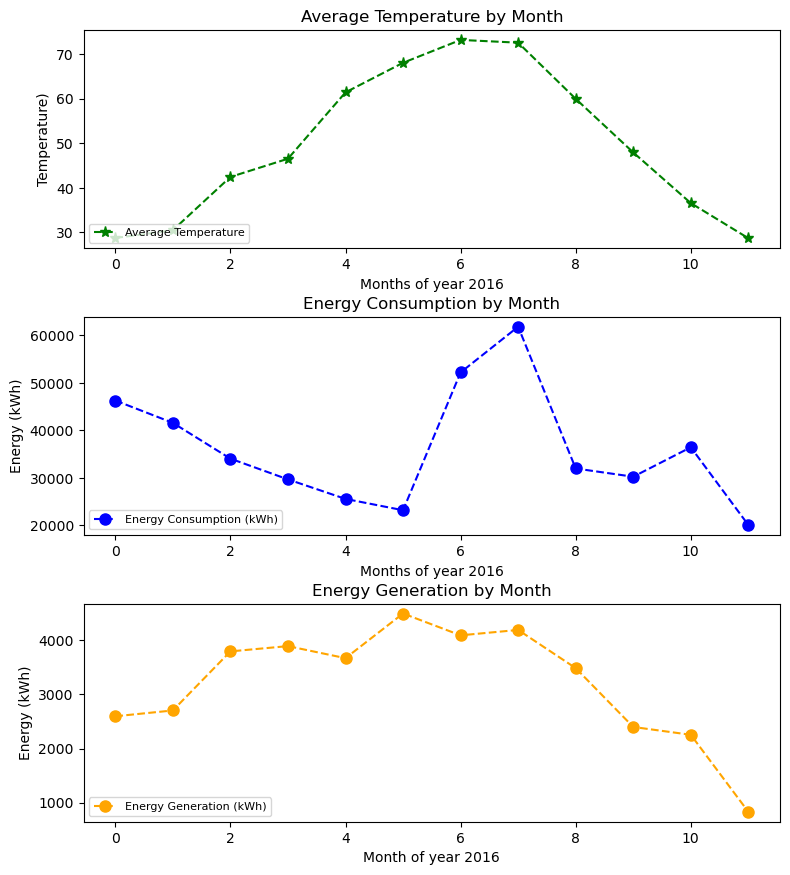

In [30]:
# Visualize the total energy consumption and generation by month
fig, ax = plt.subplots(3, 1, figsize=(8, 10), sharey=False)
ax = ax.flatten()

# Plot average temperature by month
ax[0].set_title('Average Temperature by Month')
ax[0].set_xlabel('Months of year 2016')
ax[0].set_ylabel('Temperature)')
ax[0].legend(loc='upper right')
ax[0].plot(df_aggregated_by_month['month_of_year'], df_aggregated_by_month['temperature'], 
           label='Average Temperature', marker='*', color='green', linestyle='--', markersize=8)
ax[0].legend(loc='lower left', fontsize=8)

# Plot total energy consumption by month
ax[1].plot(df_aggregated_by_month['month_of_year'], df_aggregated_by_month['use'], 
           label='Energy Consumption (kWh)', marker='o', color='blue', linestyle='--', markersize=8)
ax[1].set_title('Energy Consumption by Month')
ax[1].set_xlabel('Months of year 2016')
ax[1].set_ylabel('Energy (kWh)')
ax[1].legend(loc='lower left',fontsize=8)

# Plot total energy generation by day
ax[2].plot(df_aggregated_by_month['month_of_year'], df_aggregated_by_month['gen'], 
           label='Energy Generation (kWh)', marker='o', color='orange', linestyle='--', markersize=8)
ax[2].set_title('Energy Generation by Month')
ax[2].set_xlabel('Month of year 2016')
ax[2].set_ylabel('Energy (kWh)')
ax[2].legend(loc='lower left', fontsize=8)

# Set the overall title and layout
#plt.suptitle('Total Energy Consumption and Generation by Month', fontsize=14)
plt.tight_layout()
plt.subplots_adjust(top=0.85)  # Adjust title to fit
plt.show();


#### Comment

- **Energy Generation and Consumption Peaks**:  
  Both energy generation and consumption are highest during July and August, coinciding with peak summer temperatures.

- **Energy Consumption Trends**:  
  - A gradual decrease in energy consumption is observed during the first six months of the year.  
  - Consumption increases sharply in July and peaks in August, likely driven by increased air conditioning use during the hottest month.  
  - After August, energy consumption declines as temperatures cool.  
  - Despite December being as cold as January, energy consumption in December is at its lowest, which is an interesting anomaly.  

- **Energy Generation Patterns**:  
  - Energy generation is slightly higher in the summer months compared to other parts of the year.  
  - However, the energy generated is substantially lower than the energy consumed, highlighting a gap in supply and demand.  


### Analysis: Total Energy Generation and Consumption by Day

In [31]:
# Define columns related to energy consumption and weather data
energy_related_columns = [
    'use', 'gen', 'dishwasher_use', 'home_office_use', 'fridge_use',
    'wine_cellar_use', 'garage_door_use', 'barn_use', 'well_use',
    'microwave_use', 'living_room_use', 'furnace_use', 'kitchen_use'
]

weather_related_columns = [
    'temperature', 'humidity', 'visibility', 'pressure', 
    'windSpeed', 'windBearing', 'precipIntensity'
]

# Initialize an empty DataFrame to store aggregated data
df_aggregated_by_day = pd.DataFrame(columns=energy_related_columns + weather_related_columns)


# Aggregate energy-related data by 'month' and 'day' by summing the values
energy_aggregated_by_day = df.groupby(['month', 'day'])[energy_related_columns].sum().reset_index()

# Aggregate weather-related data by 'month' and 'day' by averaging the values
weather_aggregated_by_day = df.groupby(['month', 'day'])[weather_related_columns].mean().reset_index()

# Combine aggregated energy and weather data into a single DataFrame
df_aggregated_by_day = pd.merge(energy_aggregated_by_day, weather_aggregated_by_day, on=['month', 'day'])

# Create a column called day_of_year 
df_aggregated_by_day['day_of_year'] =  df_aggregated_by_day.index

# Display DataFrame information
df_aggregated_by_day.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 351 entries, 0 to 350
Data columns (total 23 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   month            351 non-null    int32  
 1   day              351 non-null    int32  
 2   use              351 non-null    float64
 3   gen              351 non-null    float64
 4   dishwasher_use   351 non-null    float64
 5   home_office_use  351 non-null    float64
 6   fridge_use       351 non-null    float64
 7   wine_cellar_use  351 non-null    float64
 8   garage_door_use  351 non-null    float64
 9   barn_use         351 non-null    float64
 10  well_use         351 non-null    float64
 11  microwave_use    351 non-null    float64
 12  living_room_use  351 non-null    float64
 13  furnace_use      351 non-null    float64
 14  kitchen_use      351 non-null    float64
 15  temperature      351 non-null    float64
 16  humidity         351 non-null    float64
 17  visibility      

In [32]:
df_aggregated_by_day.head()

,month,day,use,gen,dishwasher_use,home_office_use,fridge_use,wine_cellar_use,garage_door_use,barn_use,...,furnace_use,kitchen_use,temperature,humidity,visibility,pressure,windSpeed,windBearing,precipIntensity,day_of_year
0,1,1,1366.269517,18.026200,59.517171,64.668783,94.740300,29.093367,15.228367,99.622950,...,492.020017,3.873278,35.725737,0.631825,9.759298,1014.740316,7.386772,263.689474,0.000112,0
1,1,2,1851.521067,76.051300,63.154404,145.570317,74.851733,24.096767,19.246333,185.776967,...,683.761967,5.154752,31.692569,0.580056,9.953722,1014.510944,8.148319,264.529167,0.000000,1
2,1,3,1651.128133,74.081433,105.508668,196.064167,92.149033,32.989533,19.444933,146.493667,...,613.630533,6.364001,33.273625,0.613597,10.000000,1009.626375,7.616264,227.120833,0.000000,2
3,1,4,1500.686017,108.525017,58.880760,180.650867,71.016683,20.980700,19.249983,47.837017,...,605.129767,5.782085,22.297722,0.598597,9.805056,1016.432236,11.226181,319.797222,0.000000,3
4,1,5,1597.968867,148.107500,72.973254,133.360867,80.135633,30.792300,19.773067,50.166067,...,817.065250,4.918163,11.950139,0.535292,9.996375,1034.091292,6.661236,291.412500,0.000000,4


#### Visualize

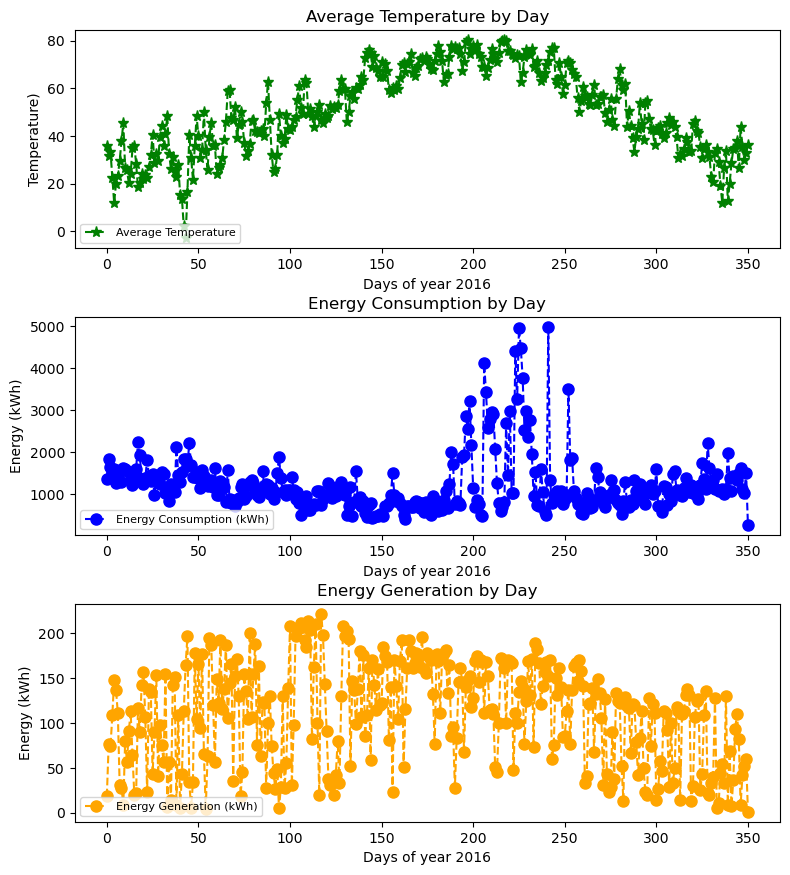

In [33]:
# Visualize the total energy consumption and generation by day
fig, ax = plt.subplots(3, 1, figsize=(8, 10), sharey=False)
ax = ax.flatten()

# Plot average temperature by day
ax[0].set_title('Average Temperature by Day')
ax[0].set_xlabel('Days of year 2016')
ax[0].set_ylabel('Temperature)')
ax[0].legend(loc='upper right')
ax[0].plot(df_aggregated_by_day['day_of_year'], df_aggregated_by_day['temperature'], 
           label='Average Temperature', marker='*', color='green', linestyle='--', markersize=8)
ax[0].legend(loc='lower left', fontsize=8)

# Plot total energy consumption by day
ax[1].plot(df_aggregated_by_day['day_of_year'], df_aggregated_by_day['use'], 
           label='Energy Consumption (kWh)', marker='o', color='blue', linestyle='--', markersize=8)
ax[1].set_title('Energy Consumption by Day')
ax[1].set_xlabel('Days of year 2016')
ax[1].set_ylabel('Energy (kWh)')
ax[1].legend(loc='lower left',fontsize=8)

# Plot total energy generation by day
ax[2].plot(df_aggregated_by_day['day_of_year'], df_aggregated_by_day['gen'], 
           label='Energy Generation (kWh)', marker='o', color='orange', linestyle='--', markersize=8)
ax[2].set_title('Energy Generation by Day')
ax[2].set_xlabel('Days of year 2016')
ax[2].set_ylabel('Energy (kWh)')
ax[2].legend(loc='lower left', fontsize=8)

# Set the overall title and layout
#plt.suptitle('Total Energy Consumption and Generation by Month', fontsize=14)
plt.tight_layout()
plt.subplots_adjust(top=0.85)  # Adjust title to fit
plt.show();


### Comment

The above visualizations provide a detailed view of seasonal patterns.  
- Temperature gradually increases towards the summer months, reaches its peak, and then slowly decreases.  
- On average, energy consumption remains stable throughout the year, except during the summer, when it peaks.  
- Energy generation fluctuates between 0 and 200 kWh per day, while energy consumption ranges from 1,000 to 5,000 kWh per day.



### Analysis: Total Energy Generation and Consumption by Hour

This analysis aims to identify specific hours of the day when energy consumption and generation are highest. For example, people may use appliances like furnaces more in the evening after returning home from work, or air conditioning during the hottest hours around noon.

#### Aggregate the dataset by hour

In [34]:
# Define columns related to energy consumption and weather data
energy_related_columns = [
    'use', 'gen', 'dishwasher_use', 'home_office_use', 'fridge_use',
    'wine_cellar_use', 'garage_door_use', 'barn_use', 'well_use',
    'microwave_use', 'living_room_use', 'furnace_use', 'kitchen_use'
]

weather_related_columns = [
    'temperature', 'humidity', 'visibility', 'pressure', 
    'windSpeed', 'windBearing', 'precipIntensity'
]

# Initialize an empty DataFrame to store aggregated data
df_aggregated_by_hour = pd.DataFrame(columns=energy_related_columns + weather_related_columns)


# Aggregate energy-related data by 'month' and 'day' by summing the values
energy_aggregated_by_hour = df.groupby(['month', 'day', 'hour'])[energy_related_columns].sum().reset_index()

# Aggregate weather-related data by 'month' and 'day' by averaging the values
weather_aggregated_by_hour = df.groupby(['month', 'day', 'hour'])[weather_related_columns].mean().reset_index()

# Combine aggregated energy and weather data into a single DataFrame
df_aggregated_by_hour = pd.merge(energy_aggregated_by_hour, weather_aggregated_by_hour, on=['month', 'day', 'hour'])

# Display DataFrame information
df_aggregated_by_hour.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8399 entries, 0 to 8398
Data columns (total 23 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   month            8399 non-null   int32  
 1   day              8399 non-null   int32  
 2   hour             8399 non-null   int32  
 3   use              8399 non-null   float64
 4   gen              8399 non-null   float64
 5   dishwasher_use   8399 non-null   float64
 6   home_office_use  8399 non-null   float64
 7   fridge_use       8399 non-null   float64
 8   wine_cellar_use  8399 non-null   float64
 9   garage_door_use  8399 non-null   float64
 10  barn_use         8399 non-null   float64
 11  well_use         8399 non-null   float64
 12  microwave_use    8399 non-null   float64
 13  living_room_use  8399 non-null   float64
 14  furnace_use      8399 non-null   float64
 15  kitchen_use      8399 non-null   float64
 16  temperature      8399 non-null   float64
 17  humidity      

In [35]:
df_aggregated_by_hour

,month,day,hour,use,gen,dishwasher_use,home_office_use,fridge_use,wine_cellar_use,garage_door_use,...,living_room_use,furnace_use,kitchen_use,temperature,humidity,visibility,pressure,windSpeed,windBearing,precipIntensity
0,1,1,5,62.647783,0.198417,0.003817,14.508850,2.271667,3.801033,0.782767,...,0.090283,23.591283,0.016411,36.131000,0.619667,10.000000,1016.888000,9.150333,282.100000,0.000000
1,1,1,6,55.090017,0.205300,0.005950,2.597617,4.531317,6.776500,0.770167,...,0.097083,27.402450,0.014972,35.838667,0.610000,10.000000,1016.232000,8.284000,284.733333,0.000000
2,1,1,7,42.884167,0.206900,0.002550,2.604967,3.569133,0.431050,0.797917,...,0.097717,22.330200,0.014528,35.385000,0.613000,10.000000,1015.989000,7.927000,279.400000,0.000000
3,1,1,8,57.600767,0.206850,0.008300,3.900833,3.624717,0.422683,0.775517,...,0.098067,36.982217,0.016111,35.282000,0.640000,10.000000,1016.042000,5.684667,265.000000,0.000000
4,1,1,9,38.390183,0.206350,0.003617,2.603500,2.106350,0.428567,0.793200,...,0.099000,20.630550,0.015917,35.451667,0.641667,10.000000,1015.815000,6.975000,265.500000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8394,12,15,23,65.819917,0.248250,0.004500,2.511183,2.654150,0.487117,0.768850,...,0.075633,46.348000,0.014634,36.990000,0.712000,9.380000,1012.775333,11.183333,189.666667,0.000373
8395,12,16,0,76.595083,0.246533,0.003568,2.502683,3.029500,6.332783,0.751583,...,0.074133,47.760350,0.012784,37.584167,0.721667,8.855333,1012.628500,11.969500,197.633333,0.004313
8396,12,16,1,75.613833,0.248483,0.006000,2.515267,2.948417,7.388033,0.764567,...,0.076550,49.405067,0.015322,36.429333,0.801000,8.576333,1012.129667,10.720667,197.900000,0.010600
8397,12,16,2,66.021450,0.249867,0.005117,2.513983,3.003783,3.944967,0.777433,...,0.076183,42.402033,0.014678,35.580833,0.836667,8.308333,1011.711667,7.361667,191.833333,0.010392


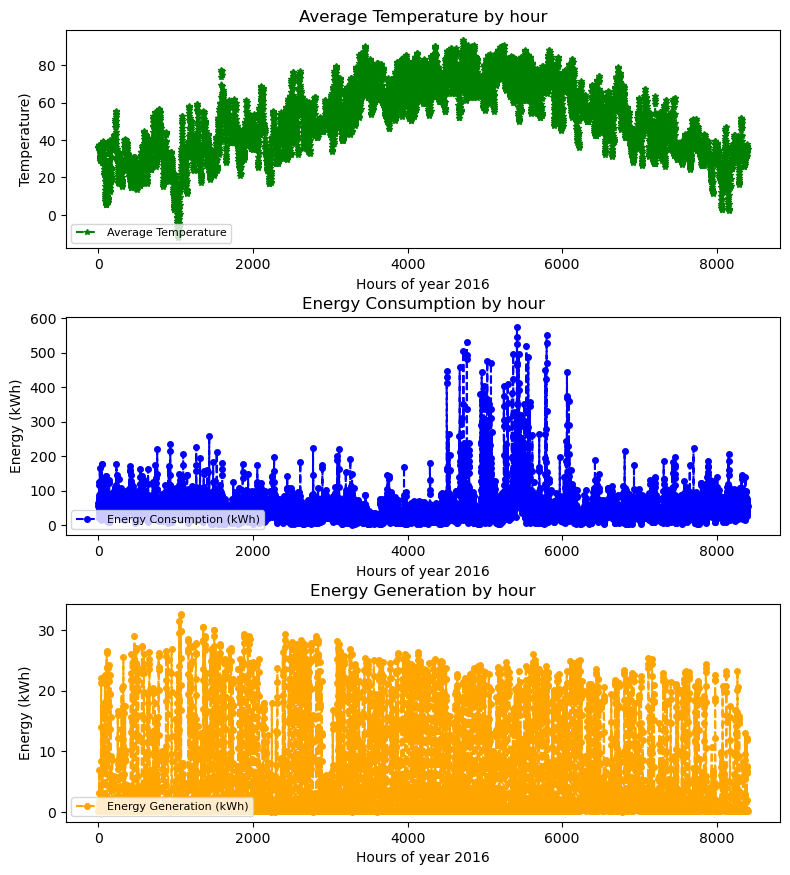

In [36]:
# Visualize the total energy consumption and generation by hour
fig, ax = plt.subplots(3, 1, figsize=(8, 10), sharey=False)
ax = ax.flatten()

# Plot average temperature by hour
ax[0].set_title('Average Temperature by hour')
ax[0].set_xlabel('Hours of year 2016')
ax[0].set_ylabel('Temperature)')
ax[0].legend(loc='upper right')
ax[0].plot(df_aggregated_by_hour.index, df_aggregated_by_hour['temperature'], 
           label='Average Temperature', marker='*', color='green', linestyle='--', markersize=4)
ax[0].legend(loc='lower left', fontsize=8)

# Plot total energy consumption by hour
ax[1].plot(df_aggregated_by_hour.index, df_aggregated_by_hour['use'], 
           label='Energy Consumption (kWh)', marker='o', color='blue', linestyle='--', markersize=4)
ax[1].set_title('Energy Consumption by hour')
ax[1].set_xlabel('Hours of year 2016')
ax[1].set_ylabel('Energy (kWh)')
ax[1].legend(loc='lower left',fontsize=8)

# Plot total energy generation by hour
ax[2].plot(df_aggregated_by_hour.index, df_aggregated_by_hour['gen'], 
           label='Energy Generation (kWh)', marker='o', color='orange', linestyle='--', markersize=4)
ax[2].set_title('Energy Generation by hour')
ax[2].set_xlabel('Hours of year 2016')
ax[2].set_ylabel('Energy (kWh)')
ax[2].legend(loc='lower left', fontsize=8)

# Set the overall title and layout
#plt.suptitle('Total Energy Consumption and Generation by Month', fontsize=14)
plt.tight_layout()
plt.subplots_adjust(top=0.85)  # Adjust title to fit
plt.show();


#### Comment

 However, the current visualization makes it difficult to identify clear hourly patterns.


## Impact of Weather Conditions on Energy Consumption/Generation:
### Heat, Humidity, Visibility, and More

In [37]:
weather_columns = ['temperature', 'humidity','visibility', 'pressure', 'windSpeed', 'windBearing', 'precipIntensity']

#### Visualize the relationship between energy usage and different weather properties

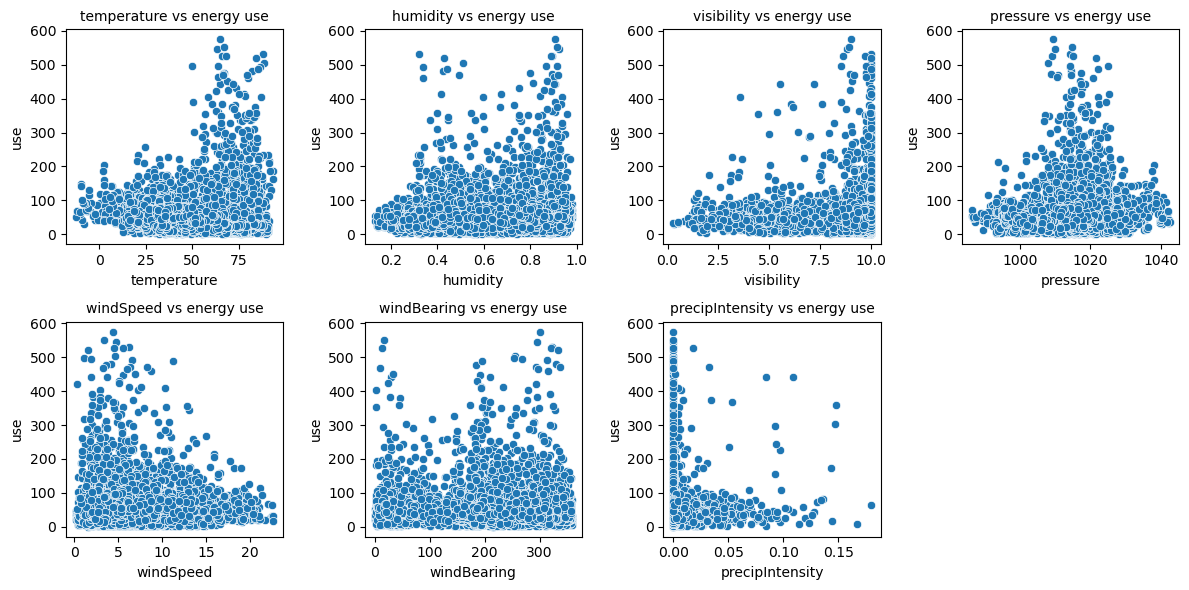

In [38]:
fig, ax = plt.subplots(2, 4, figsize=(12, 6))
ax = ax.flatten()  # Flatten the array of axes for easier iteration

for i, weather_prop in enumerate(weather_columns):
    sns.scatterplot(
        x=df_aggregated_by_hour[weather_prop], 
        y=df_aggregated_by_hour['use'], 
        ax=ax[i]
    )
    ax[i].set_title(f"{weather_prop} vs energy use", fontsize=10) 


if len(weather_columns) < len(ax): 
    for unused_idx in range(len(weather_columns), len(ax)):
        ax[unused_idx].set_axis_off()

plt.tight_layout()



#### Comment

Each scatter plot illustrates the relationship between a specific weather attribute (e.g., temperature, humidity) and energy consumption, highlighting potential patterns or trends.

- The plots indicate that energy consumption increases as temperature, humidity, and visibility rise.  
- When atmospheric pressure is around 1020, energy usage reaches its peak.  
- Energy consumption is highest when wind speed is low and precipitation intensity is minimal.  

While this analysis examines energy usage trends based on individual weather attributes, energy consumption is influenced by the combined effect of all weather properties. Therefore, analyzing each attribute separately may not provide the most accurate or comprehensive insights.


#### Visualize the relationship between energy generation and different weather properties

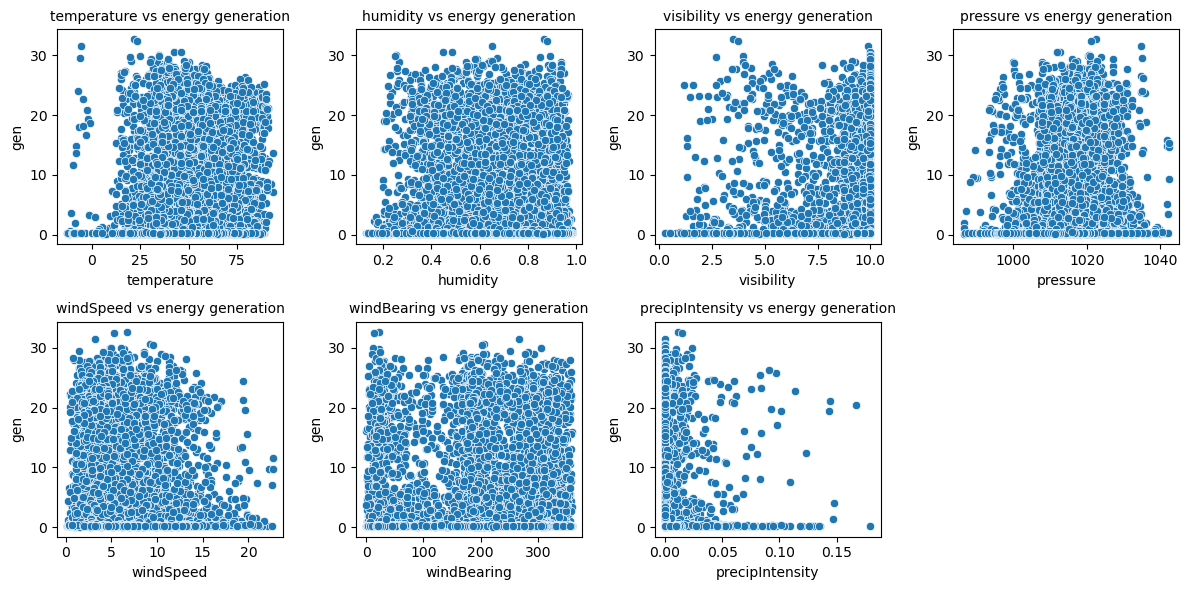

In [39]:
fig, ax = plt.subplots(2, 4, figsize=(12, 6))
ax = ax.flatten()  # Flatten the array of axes for easier iteration

for i, weather_prop in enumerate(weather_columns):
    sns.scatterplot(
        x=df_aggregated_by_hour[weather_prop], 
        y=df_aggregated_by_hour['gen'], 
        ax=ax[i]
    )
    ax[i].set_title(f"{weather_prop} vs energy generation", fontsize=10) 


if len(weather_columns) < len(ax): 
    for unused_idx in range(len(weather_columns), len(ax)):
        ax[unused_idx].set_axis_off()

plt.tight_layout()

#### Comment

Each scatter plot shows the relationship between a specific weather attribute (e.g., temperature, humidity) and energy generation, highlighting possible patterns.

- Energy generation is highest when precipitation is minimal, and the temperature is above ~10°F.  
- No clear trends were observed between energy generation and other weather attributes.  

However, energy generation is affected by the combined influence of all weather properties. Analyzing them individually may not provide a complete picture.


## Modeling

1. Time Series Modeling
2. Feedforward Neural Networks



## Time Series Modelling

Exploratory data analysis identified a monthly cyclic pattern in energy consumption, typically increasing in the middle of the month, except during the summer months when consumption peaks.

Based on these insights, I will use the aggregated the data on a daily basis to analyze the cyclic patterns over a ~30-day period (1 month)

In [40]:
df_aggregated_by_day

,month,day,use,gen,dishwasher_use,home_office_use,fridge_use,wine_cellar_use,garage_door_use,barn_use,...,furnace_use,kitchen_use,temperature,humidity,visibility,pressure,windSpeed,windBearing,precipIntensity,day_of_year
0,1,1,1366.269517,18.026200,59.517171,64.668783,94.740300,29.093367,15.228367,99.622950,...,492.020017,3.873278,35.725737,0.631825,9.759298,1014.740316,7.386772,263.689474,0.000112,0
1,1,2,1851.521067,76.051300,63.154404,145.570317,74.851733,24.096767,19.246333,185.776967,...,683.761967,5.154752,31.692569,0.580056,9.953722,1014.510944,8.148319,264.529167,0.000000,1
2,1,3,1651.128133,74.081433,105.508668,196.064167,92.149033,32.989533,19.444933,146.493667,...,613.630533,6.364001,33.273625,0.613597,10.000000,1009.626375,7.616264,227.120833,0.000000,2
3,1,4,1500.686017,108.525017,58.880760,180.650867,71.016683,20.980700,19.249983,47.837017,...,605.129767,5.782085,22.297722,0.598597,9.805056,1016.432236,11.226181,319.797222,0.000000,3
4,1,5,1597.968867,148.107500,72.973254,133.360867,80.135633,30.792300,19.773067,50.166067,...,817.065250,4.918163,11.950139,0.535292,9.996375,1034.091292,6.661236,291.412500,0.000000,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
346,12,12,1617.835017,8.129833,0.108675,59.676483,64.955017,40.523333,22.473050,47.439633,...,567.282667,3.558341,43.898000,0.792965,8.139528,1015.268514,9.628493,213.577083,0.001077,346
347,12,13,1133.408117,41.989967,70.469589,59.511567,82.265933,30.369767,19.151850,48.607150,...,480.261467,3.422514,35.555826,0.617097,9.892333,1014.644944,9.807250,298.526389,0.000000,347
348,12,14,1026.850250,52.339200,0.095493,59.465533,75.854333,39.065917,21.250750,48.728567,...,519.290850,1.911386,29.963292,0.782819,7.431125,1013.819625,4.039736,171.723611,0.009142,348
349,12,15,1508.666433,59.329550,73.094186,60.550000,62.367067,25.967883,18.775450,45.537250,...,791.562067,1.985962,32.682153,0.753951,8.815250,999.368792,10.321722,264.139583,0.001153,349


In [41]:
df_time_series = df_aggregated_by_day[['day_of_year', 'use']]
df_time_series.head()

,day_of_year,use
0,0,1366.269517
1,1,1851.521067
2,2,1651.128133
3,3,1500.686017
4,4,1597.968867


In [42]:
df_time_series.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 351 entries, 0 to 350
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   day_of_year  351 non-null    int64  
 1   use          351 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 5.6 KB


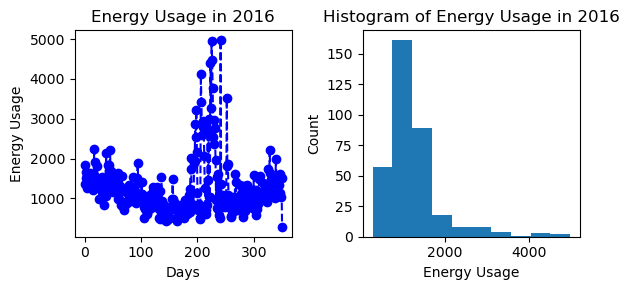

In [43]:
fig, ax = plt.subplots(1, 2, figsize=(6,3))

ax[0].plot(df_time_series['day_of_year'], df_time_series['use'], 'bo--')
ax[0].set_ylabel("Energy Usage")
ax[0].set_xlabel("Days")
ax[0].set_title("Energy Usage in 2016")


ax[1].hist(df_time_series['use'])
ax[1].set_ylabel("Count")
ax[1].set_xlabel("Energy Usage")
ax[1].set_title("Histogram of Energy Usage in 2016")

plt.tight_layout()

#### Apply ADF test to check if a time series requires differencing to become stationary

In [44]:
# Test if data is stationary with ADF test
adf_result = adfuller(df_time_series['use'])
df_adf_result = pd.DataFrame({
    "ADF Statistic": [adf_result[0]],
    "p-value":[adf_result[1]],
    "Critical_Value_1%":[adf_result[4]['1%']],
    "Critical_Value_5%":[adf_result[4]['5%']],
    "Critical_Value_10%":[adf_result[4]['10%']]
})

df_adf_result

,ADF Statistic,p-value,Critical_Value_1%,Critical_Value_5%,Critical_Value_10%
0,-3.044505,0.030942,-3.44973,-2.870079,-2.571319


#### Comment
As the p-value is under 0.05, this series is **stationary**. 

### ACF (Autocorrelation Function) plot and PACF (Partial Autocorrelation Function) plot

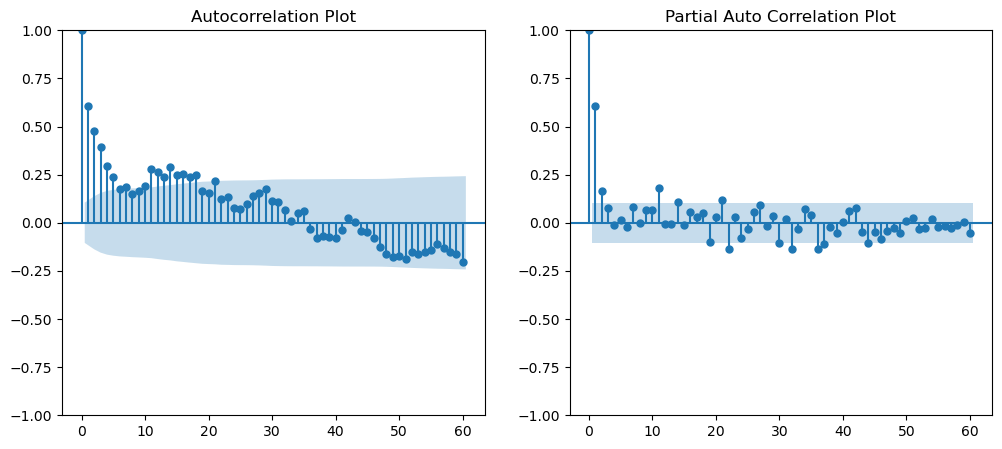

In [45]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax = ax.flatten()
plot_acf(df_time_series['use'], ax=ax[0], lags=60, title="Autocorrelation Plot")
plot_pacf(df_time_series['use'], ax=ax[1], lags=60, title="Partial Auto Correlation Plot")
plt.show()

#### Comment
In summary, the ACF plot indicates that the time series has strong correlations at specific lags, suggesting certain periodic patterns or dependencies in the data at those intervals.


### Perform a time series decomposition into the trend, seasonality, and residuals 

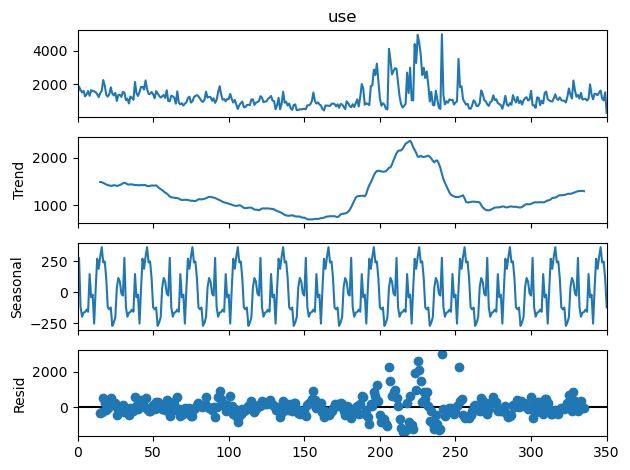

In [46]:
decomposition = seasonal_decompose(df_time_series['use'], model='additive', period=30)
decomposition.plot()
plt.show()

#### Comment
* The **trend component** shows a consistent downward movement leading up to the summer months, followed by a peak during the summer, and then a decline as the weather cools. There is a slight increase again during the winter months.
* The **seasonal component** exhibits a clear monthly pattern, as expected. Seasonality ranges between -250 and 250. However, considering the trend's scale (ranging from 1000 to 2000), the seasonal fluctuations are relatively significant.
* **Residuals** are higher during the summer months, indicating a noticeable pattern in energy consumption during this period.


#### Develop a Diagnostic Function to Evaluate Time Series Models

In [47]:
# Create a group of plots for diagnostics 
def visualize_diagnostics(data):
    # data: residuals of the fitted model
    fig = plt.figure(figsize=(20,12))
    layout = (3, 2)

    data_ax = plt.subplot2grid(layout, (0, 0), colspan=1)
    hist_ax = plt.subplot2grid(layout, (0, 1), colspan=1)
    acf_ax = plt.subplot2grid(layout, (1, 0), colspan=1)
    pacf_ax = plt.subplot2grid(layout, (1, 1), colspan=1)
    qq_ax = plt.subplot2grid(layout, (2, 0), colspan=1)
    lbox_ax = plt.subplot2grid(layout, (2, 1), colspan=1)
    
    lbox_df = acorr_ljungbox(data, lags=None, return_df=True)
    
    data.plot(ax=data_ax, title="Residuals")

    data.hist(ax=hist_ax)
    hist_ax.set_title("Histogram of residuals")

    plot_acf(data, ax=acf_ax)
    plot_pacf(data, ax=pacf_ax)

    qqplot(data, ax=qq_ax, line='q')
    qq_ax.set_title("Q-Q plot")

    lbox_ax.plot(lbox_df.lb_pvalue)
    lbox_ax.axhline(y=0.05, color='r', linestyle='--', label='Significance Level (0.05)')
    lbox_ax.set_title("Ljung-Box")

### Applying ARIMA model

                               SARIMAX Results                                
Dep. Variable:                    use   No. Observations:                  351
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -2700.289
Date:                Mon, 16 Dec 2024   AIC                           5408.578
Time:                        16:19:11   BIC                           5424.021
Sample:                             0   HQIC                          5414.725
                                - 351                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1232.9881    154.445      7.983      0.000     930.282    1535.694
ar.L1          0.7892      0.041     19.417      0.000       0.710       0.869
ma.L1         -0.2966      0.055     -5.411      0.0

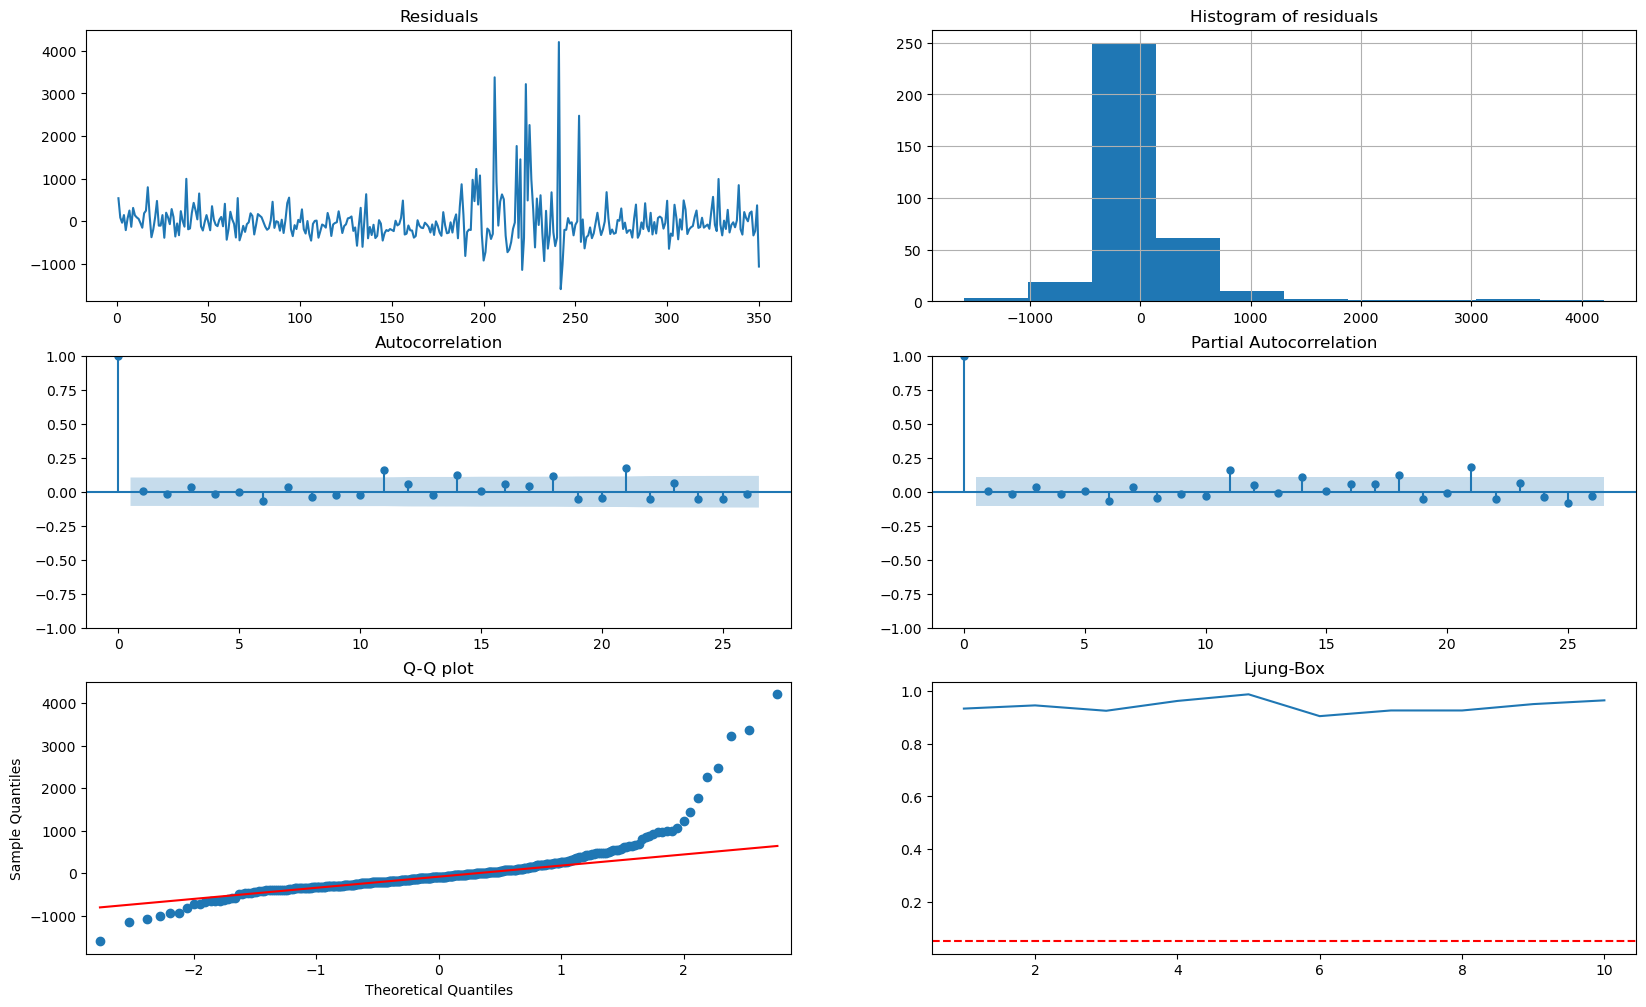

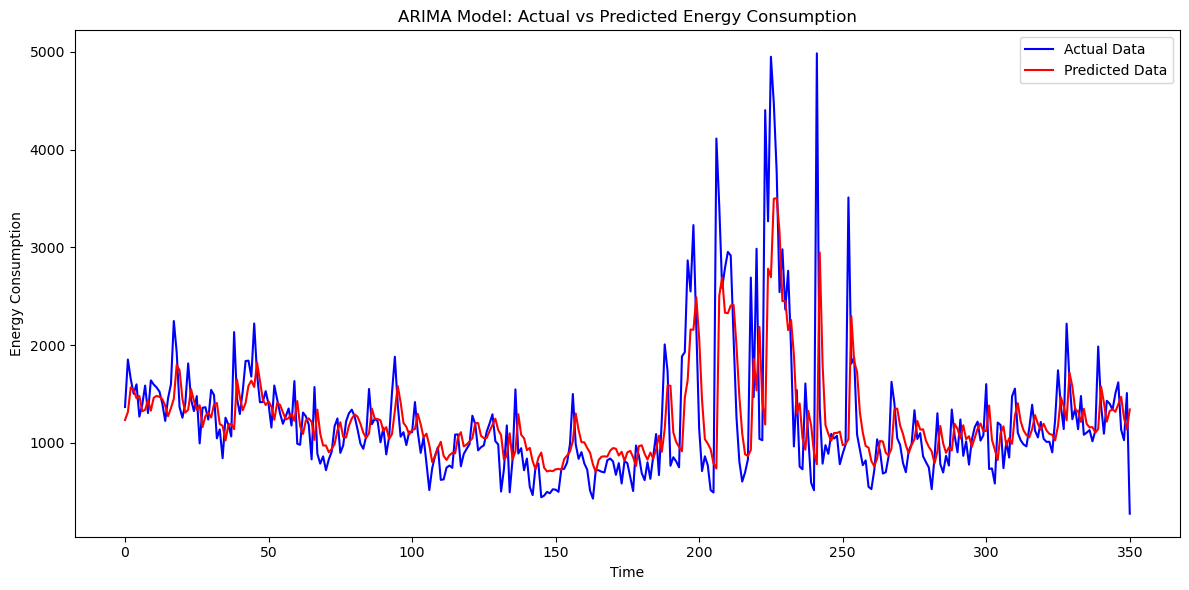

In [48]:
# parameters in ARIMA model
p = 1 #Number of lagged observations in the AR component (check PACF plot).

d = 0 #Number of differencing operations to make the series stationary (The data is stationary=>check adfuller test)

q = 1 # Number of lagged forecast errors in the MA component (check ACF plot)


arima_model = ARIMA(df_time_series['use'], order=(p,d,q))
arima_model_fitted = arima_model.fit()

# Print model summary
print(arima_model_fitted.summary())

# Plot diagnostics
visualize_diagnostics(arima_model_fitted .resid[1:])


predictions = arima_model_fitted.predict(start=0, end=len(df_time_series)-1, typ='levels')

# Step 4: Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(df_time_series['use'], label="Actual Data", color='blue')
plt.plot(predictions, label="Predicted Data", color='red', linestyle='-')
plt.title("ARIMA Model: Actual vs Predicted Energy Consumption")
plt.xlabel("Time")
plt.ylabel("Energy Consumption")
plt.legend()
plt.tight_layout()
plt.show()

In [49]:
# Calculate the Mean Absolute Error (MAE) of the predictions
mae_arima = mean_absolute_error(df_time_series['use'].values, predictions)

# Calculate average daily energy consumption
avg_daily_energy_consumption = df_time_series['use'].mean()

# Calculate the percentage of error relative to average daily energy consumption
arima_error_percent = (mae_arima / avg_daily_energy_consumption) * 100

# Print results
print(f"Average Daily Energy Consumption: {avg_daily_energy_consumption:.2f} kWh")
print(f"Mean Absolute Error (MAE) of ARIMA Model: {mae_arima:.2f} kWh")
print(f"Prediction Error Percentage: {arima_error_percent:.2f}%")

Average Daily Energy Consumption: 1233.16 kWh
Mean Absolute Error (MAE) of ARIMA Model: 308.14 kWh
Prediction Error Percentage: 24.99%


#### Comment

- **Prediction Accuracy**:  
  The predictions closely align with the actual data, successfully capturing both the increasing and decreasing trends.  

- **Residual Analysis**:  
  - The **Q-Q plot** shows that residuals deviate from a normal distribution, indicating some remaining patterns or issues.  
  - The **Ljung-Box test** confirms that the residuals behave as random noise as expected.  

- **Conclusion**:  
  While the model effectively captures the primary patterns in the data, further refinement may be needed to address the non-normality observed in the residuals.  


### Apply Auto-ARIMA for Optimal Model Selection

In [50]:
# Fit AutoARIMA model
auto_arima_model = pm.auto_arima(df_time_series['use'], seasonal=True, m=12, stepwise=True, trace=True)

print(auto_arima_model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=5411.672, Time=1.08 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=5579.233, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=5418.331, Time=0.12 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=5467.613, Time=0.25 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=6087.800, Time=0.01 sec
 ARIMA(2,0,2)(0,0,1)[12] intercept   : AIC=5410.069, Time=0.73 sec
 ARIMA(2,0,2)(0,0,0)[12] intercept   : AIC=5410.025, Time=0.20 sec
 ARIMA(2,0,2)(1,0,0)[12] intercept   : AIC=5409.795, Time=0.61 sec
 ARIMA(2,0,2)(2,0,0)[12] intercept   : AIC=5410.666, Time=1.85 sec
 ARIMA(2,0,2)(2,0,1)[12] intercept   : AIC=5411.575, Time=1.83 sec
 ARIMA(1,0,2)(1,0,0)[12] intercept   : AIC=5412.970, Time=0.30 sec
 ARIMA(2,0,1)(1,0,0)[12] intercept   : AIC=5412.319, Time=0.38 sec
 ARIMA(3,0,2)(1,0,0)[12] intercept   : AIC=5414.707, Time=0.49 sec
 ARIMA(2,0,3)(1,0,0)[12] intercept   : AIC=5411.725, Time=0.91 sec
 ARIMA(1,0,1)(1,0,0

### Comment

The Auto-ARIMA model has suggested the optimal parameters as p = 2, d = 0, q = 2, with a seasonal component of (1, 0, 0). Based on these parameters, we can proceed to apply the SARIMA (Seasonal ARIMA) model, which incorporates both non-seasonal and seasonal components, for more accurate time series forecasting.


In [51]:
### Apply SARIMA Model

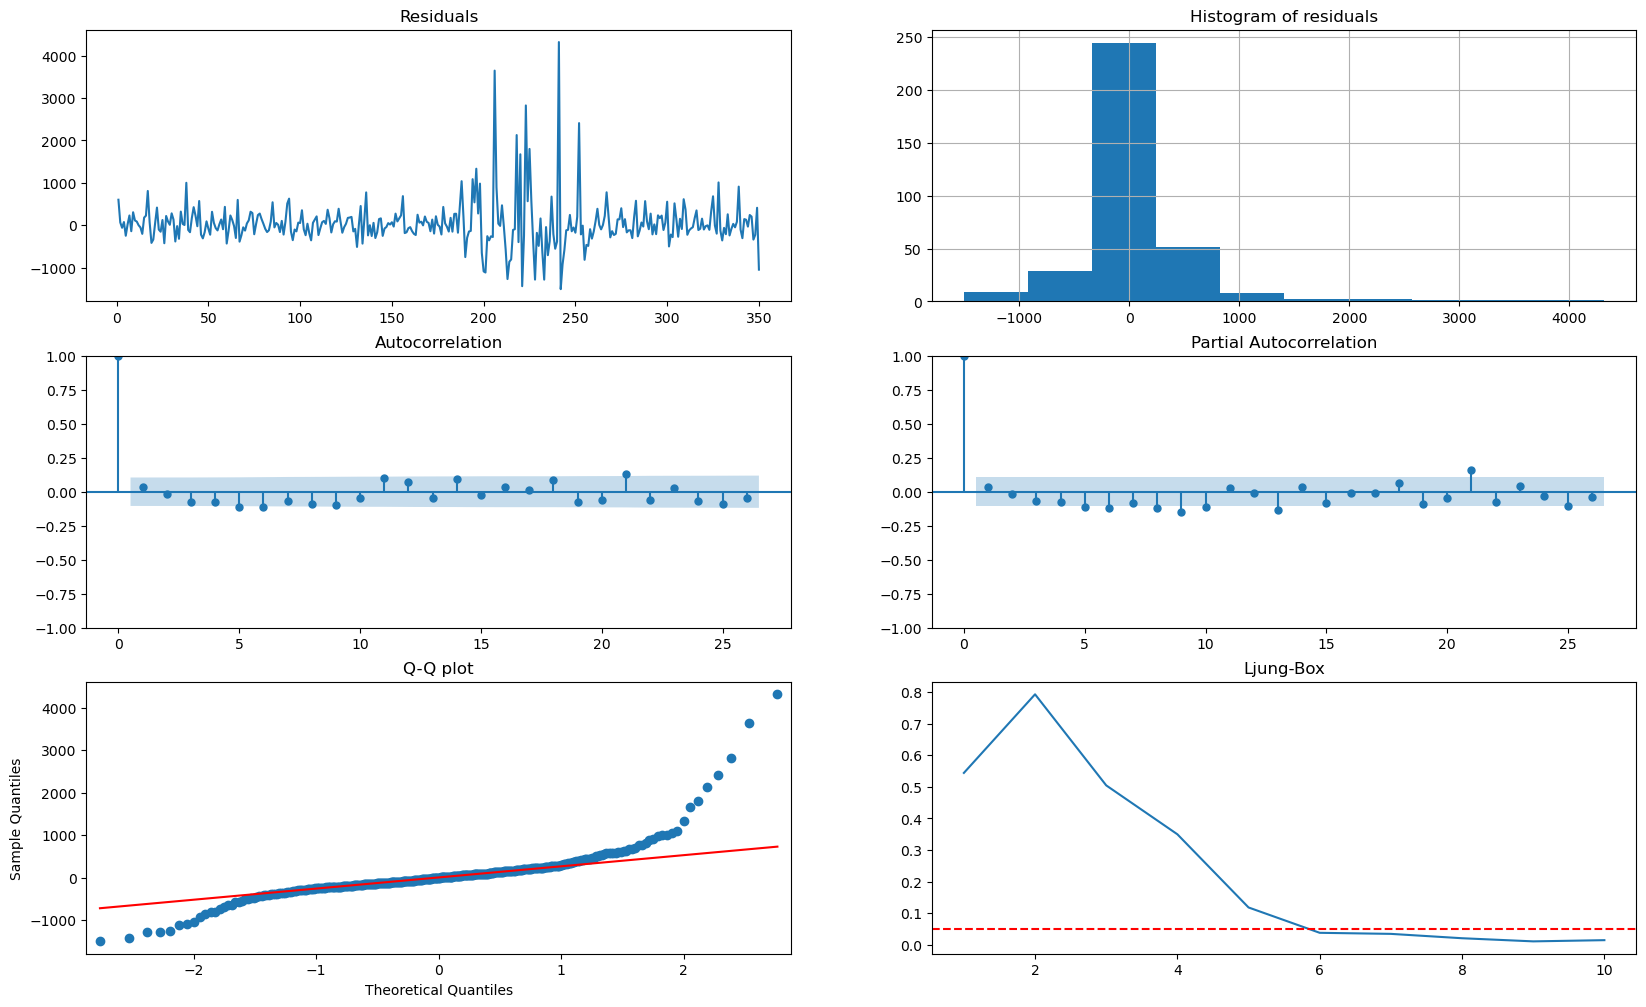

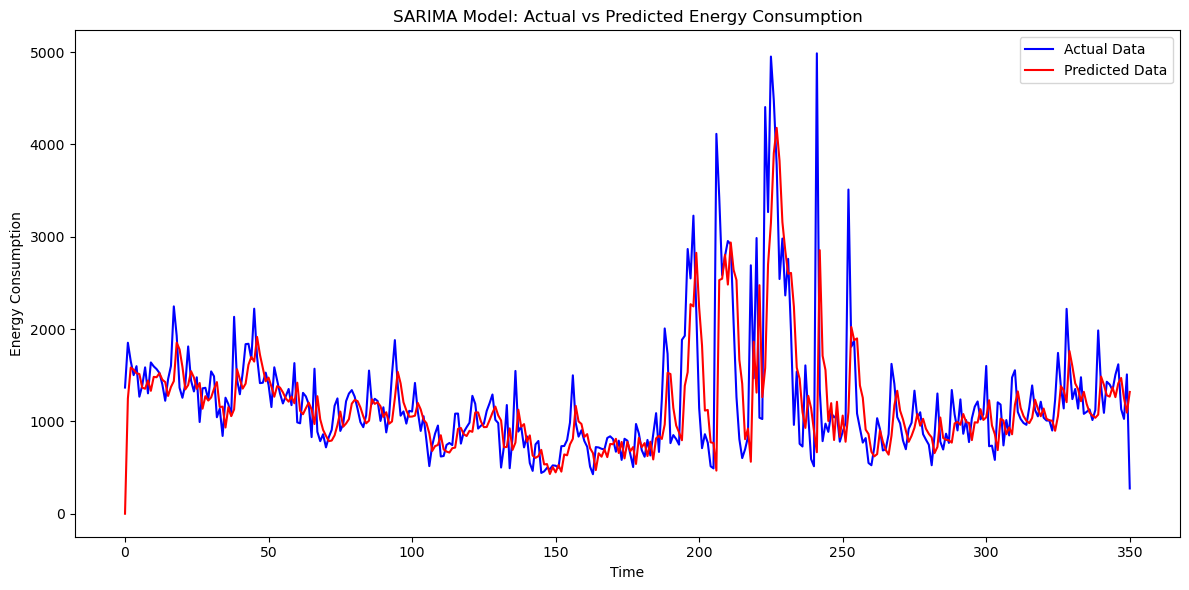

In [52]:
p, d, q = 2, 0, 2
P, D, Q, s  = 1, 0, 1, 12
sarima_model = SARIMAX(df_time_series['use'], order=(p, d, q), seasonal_order=(P, D, Q, s))
sarima_model_fitted = sarima_model.fit(disp=False)

# Visualize Diagnostic Plots for Residuals
visualize_diagnostics(sarima_model_fitted.resid[1:])

## Visualize the Fitted Data vs Actual Data
predictions_sarima = sarima_model_fitted.predict(start=0, end=len(df_time_series)-1, typ='levels')

plt.figure(figsize=(12, 6))
plt.plot(df_time_series['use'], label="Actual Data", color='blue')
plt.plot(predictions_sarima, label="Predicted Data", color='red', linestyle='-')
plt.title("SARIMA Model: Actual vs Predicted Energy Consumption")
plt.xlabel("Time")
plt.ylabel("Energy Consumption")
plt.legend()
plt.tight_layout()
plt.show()

In [53]:
# Calculate the Mean Absolute Error (MAE) of the predictions
mae_sarima = mean_absolute_error(df_time_series['use'].values, predictions_sarima)

# Calculate average daily energy consumption
avg_daily_energy_consumption = df_time_series['use'].mean()

# Calculate the percentage of error relative to average daily energy consumption
sarima_error_percent = (mae_sarima / avg_daily_energy_consumption) * 100

# Print results
print(f"Average Daily Energy Consumption: {avg_daily_energy_consumption:.2f} kWh")
print(f"Mean Absolute Error (MAE) of SARIMA Model: {mae_sarima:.2f} kWh")
print(f"Prediction Error Percentage: {sarima_error_percent:.2f}%")

Average Daily Energy Consumption: 1233.16 kWh
Mean Absolute Error (MAE) of SARIMA Model: 312.31 kWh
Prediction Error Percentage: 25.33%


#### Comment

- **Prediction Accuracy**:  
  The predictions align closely with the actual data, successfully capturing both the increasing and decreasing trends observed in the time series.

- **Residual Analysis**:  
  - The **Q-Q plot** indicates that the residuals deviate from a normal distribution, suggesting that there are still some underlying patterns or issues in the model.  
  - The **Ljung-Box test** reveals that the residuals are not behaving as random noise, which implies that the model has not fully captured all the underlying temporal dependencies.

- **Conclusion**:  
  While the model effectively captures the overall patterns in the data, further refinement is needed to address the observed non-normality and non-randomness in the residuals. 

### Apply Holt-winters Model

In [54]:
holt_winters_model = ExponentialSmoothing(df_time_series['use'], 
                              trend='add',  
                              seasonal='add',
                              seasonal_periods=12).fit() 

In [55]:
holt_winters_model.summary()

Dep. Variable:,use,No. Observations:,351
Model:,ExponentialSmoothing,SSE,110053137.510
Optimized:,True,AIC,4474.146
Trend:,Additive,BIC,4535.919
Seasonal:,Additive,AICC,4476.207
Seasonal Periods:,12,Date:,"Mon, 16 Dec 2024"
Box-Cox:,False,Time:,16:19:25
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.4997362,alpha,True
smoothing_trend,0.0003635,beta,True


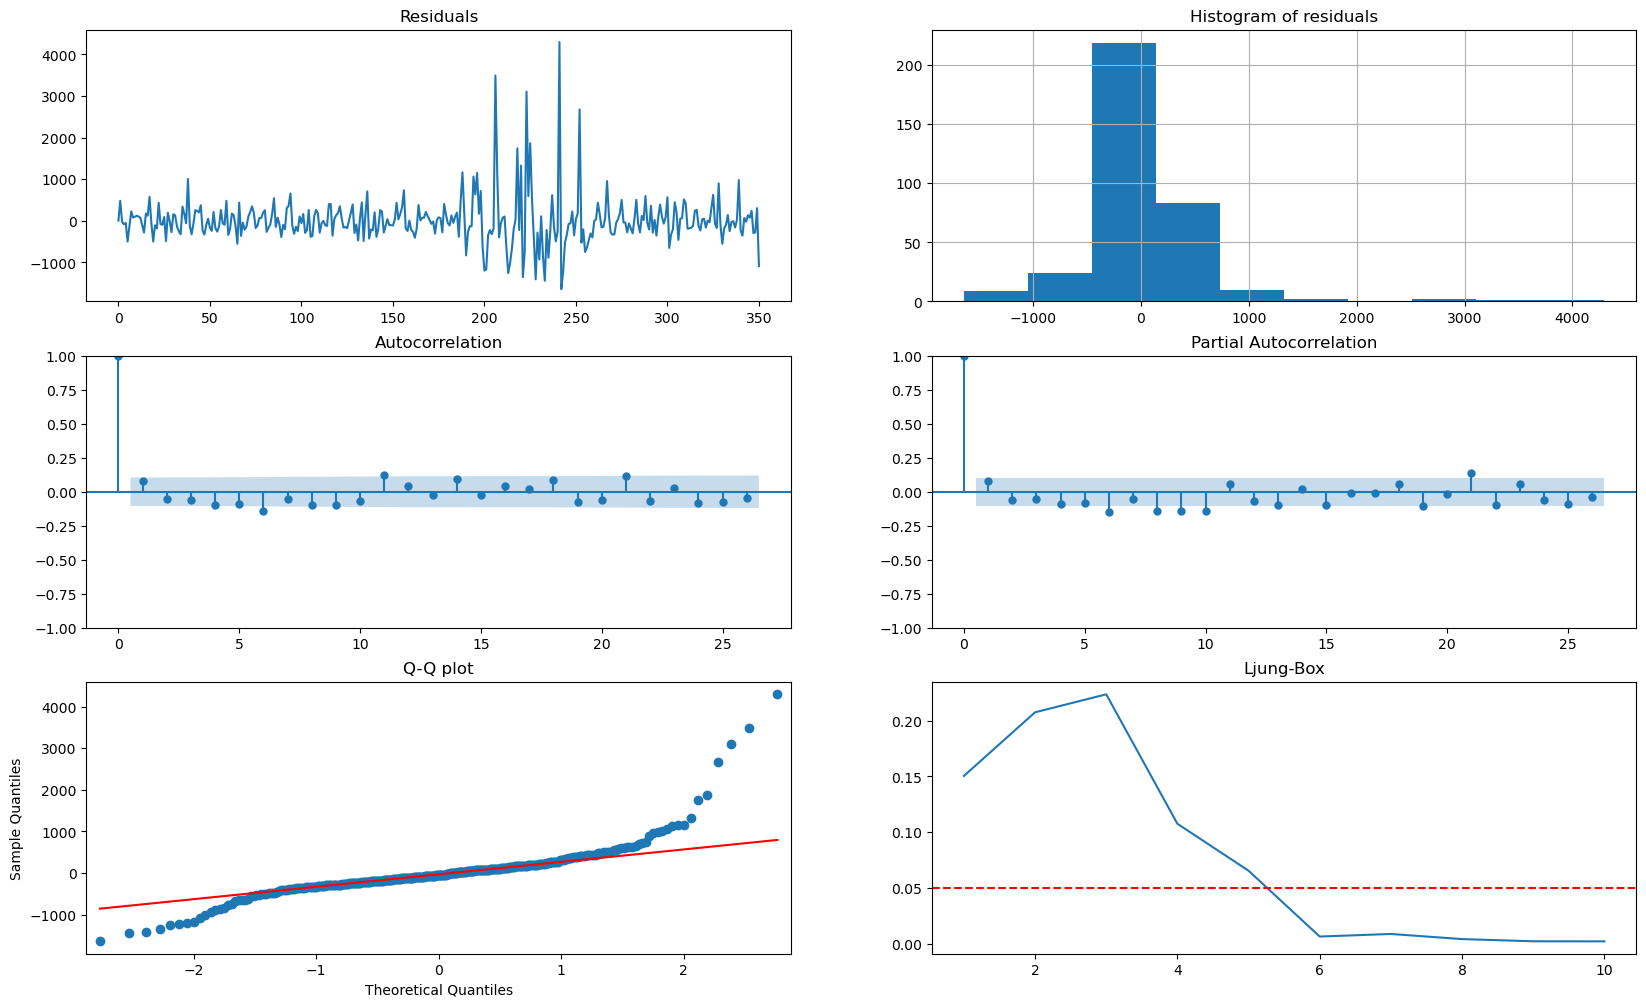

In [56]:
visualize_diagnostics(holt_winters_model.resid)

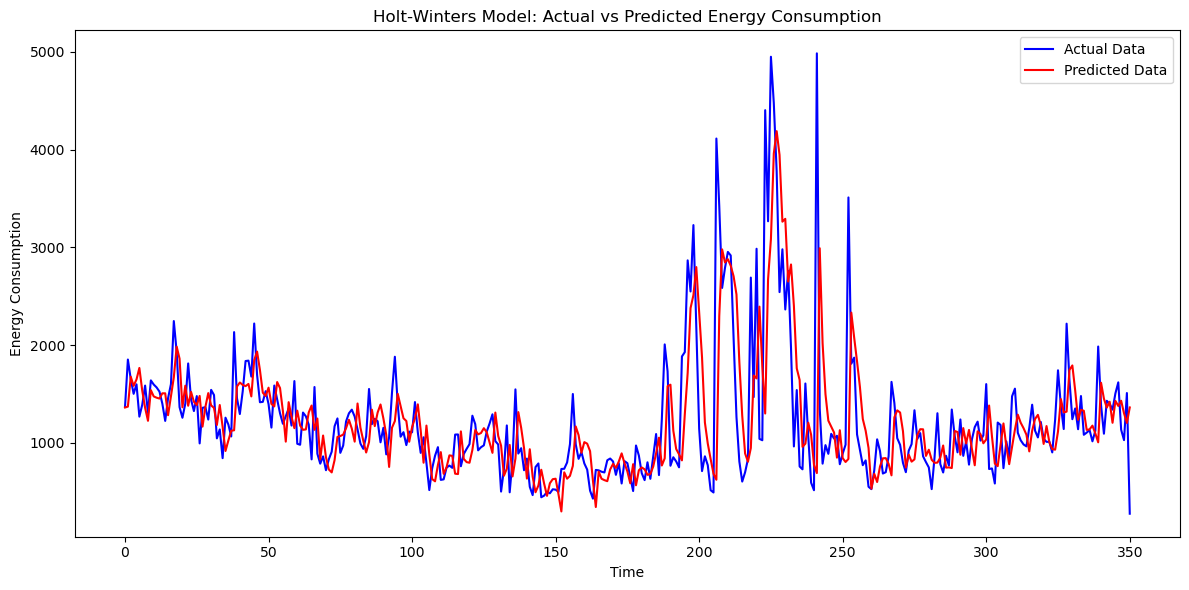

In [57]:
## Visualize the Fitted Data vs Actual Data
predictions_holt_winters = holt_winters_model.predict(start=0, end=len(df_time_series)-1)

plt.figure(figsize=(12, 6))
plt.plot(df_time_series['use'], label="Actual Data", color='blue')
plt.plot(predictions_holt_winters, label="Predicted Data", color='red', linestyle='-')
plt.title("Holt-Winters Model: Actual vs Predicted Energy Consumption")
plt.xlabel("Time")
plt.ylabel("Energy Consumption")
plt.legend()
plt.tight_layout()
plt.show()

In [58]:
# Calculate the Mean Absolute Error (MAE) of the predictions
mae_holt_winters = mean_absolute_error(df_time_series['use'].values, predictions_holt_winters)

# Calculate average daily energy consumption
avg_daily_energy_consumption = df_time_series['use'].mean()

# Calculate the percentage of error relative to average daily energy consumption
holt_winters_error_percent = (mae_holt_winters / avg_daily_energy_consumption) * 100

# Print results
print(f"Average Daily Energy Consumption: {avg_daily_energy_consumption:.2f} kWh")
print(f"Mean Absolute Error (MAE) of SARIMA Model: {mae_holt_winters:.2f} kWh")
print(f"Prediction Error Percentage: {holt_winters_error_percent:.2f}%")

Average Daily Energy Consumption: 1233.16 kWh
Mean Absolute Error (MAE) of SARIMA Model: 330.81 kWh
Prediction Error Percentage: 26.83%


## Model 2: Feed Forward Neural Network
Since neural networks require relatively large datasets for effective training, I will use the data aggregated on an hourly basis.

In [59]:
predictors = ['hour', 'dishwasher_use','home_office_use', 'fridge_use', 'wine_cellar_use', 'garage_door_use',
       'barn_use', 'well_use', 'microwave_use', 'living_room_use',
       'furnace_use', 'kitchen_use', 'temperature', 'humidity', 'visibility',
       'pressure', 'windSpeed', 'windBearing', 'precipIntensity']
target = ['use']

In [60]:
# Normalize/standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_aggregated_by_hour[predictors])
y = df_aggregated_by_hour[target].values

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y , test_size=0.2, random_state=42)

In [61]:
model = models.Sequential()

# Input layer
model.add(layers.InputLayer(input_shape=(X_train.shape[1],)))

# Hidden layers
model.add(layers.Dense(64, activation='relu')) 
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(16, activation='relu'))
# Output layer
model.add(layers.Dense(1))  

# Compile the model
model.compile(optimizer='adam', loss='mae') 

In [62]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,905 (15.25 KB)

 Trainable params: 3,905 (15.25 KB)

 Non-trainable params: 0 (0.00 B)

In [63]:
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=1)


Epoch 1/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 761us/step - loss: 44.7218 - val_loss: 15.6348
Epoch 2/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 490us/step - loss: 15.7794 - val_loss: 14.1068
Epoch 3/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 484us/step - loss: 14.7922 - val_loss: 13.5615
Epoch 4/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 498us/step - loss: 14.5216 - val_loss: 13.1580
Epoch 5/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 493us/step - loss: 13.5717 - val_loss: 12.7584
Epoch 6/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 480us/step - loss: 12.9801 - val_loss: 12.4778
Epoch 7/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 499us/step - loss: 13.1424 - val_loss: 12.0664
Epoch 8/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 501us/step - loss: 13.0477 - val_loss: 11.6592
Epoch 9/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 490us/step - loss: 12.7913 - val_loss: 11.3569
Epoch 10/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 478us/step - loss: 11.7655 - val_loss: 11.0661
Epoch 11/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 492us/step - loss: 11.2962 - val_loss: 10.59

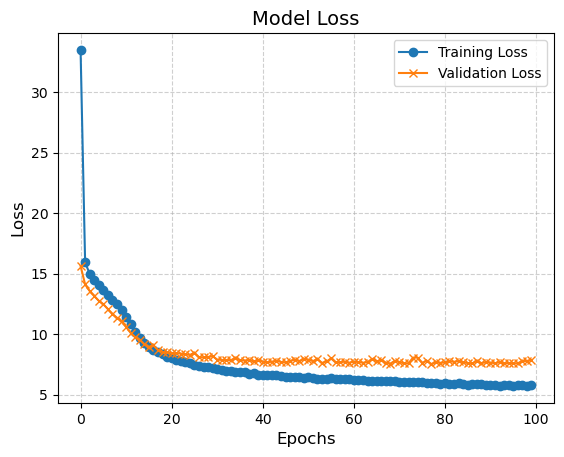

In [64]:
# Plot loss
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='x')
plt.title('Model Loss', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=10)
plt.show();

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 355us/step - loss: 8.7132
Test Loss: 8.280726432800293
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 583us/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 284us/step


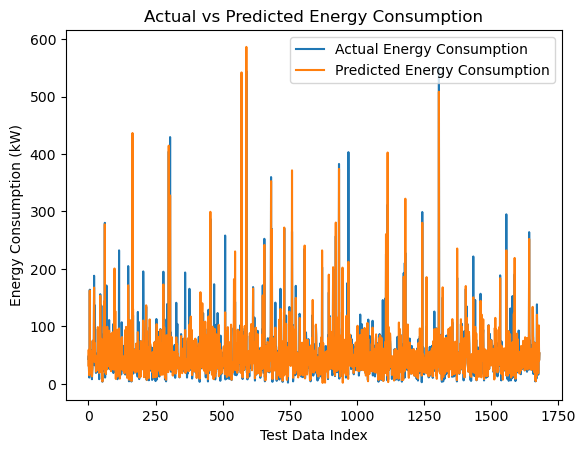

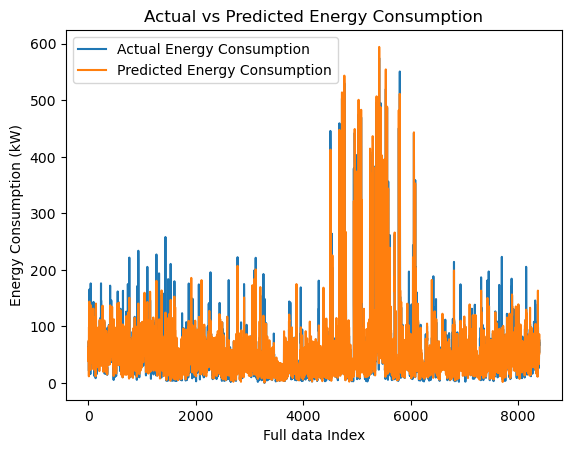

In [65]:
# Evaluate the model on the test data
test_loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")

# Predict energy consumption for the test set
y_test_pred = model.predict(X_test)
y_full_pred = model.predict(X_scaled)
plt.plot(y_test, label='Actual Energy Consumption')
plt.plot(y_test_pred, label='Predicted Energy Consumption')
plt.legend()
plt.xlabel('Test Data Index')
plt.ylabel('Energy Consumption (kW)')
plt.title('Actual vs Predicted Energy Consumption')
plt.show()

plt.plot(y, label='Actual Energy Consumption')
plt.plot(y_full_pred, label='Predicted Energy Consumption')
plt.legend()
plt.xlabel('Full data Index')
plt.ylabel('Energy Consumption (kW)')
plt.title('Actual vs Predicted Energy Consumption')
plt.show()

### Comment
I applied a simple feedforward neural network to predict total energy consumption in the smart home. The model effectively captures patterns in energy usage and can predict energy consumption with a mean absolute error (MAE) of 7, which is relatively small compared to the average energy consumption of ~ 51 kW (loss~ 13%). This indicates that the model provides reasonably accurate predictions, though there is potential for further optimization.
